# Table of Contents:

[0. Making imports](#zero)

[1. The data](#one)
- [1.0 Exploring the data](#onezero)
- [1.1 Creating ways to interacts with the data](#oneone)
- [1.2 Preparing the data for training/testing](#onetwo)

[2. The Adversarial Autoencoder (AAE)](#two)
- [2.0 Defining the AAE architecture](#twozero)
- [2.1 Creating a way to load the model](#twoone)
- [2.2 Creating the training loop](#twotwo)
- [2.3 Defining a way to visualize the metrics](#twothree)
- [2.4 Defining a way to evaluate the model](#twofour)

[3. Training the AAE from scratch](#three)
- [3.0 Training the model](#threezero)
- [3.1 Visualizing the training metrics](#threeone)
- [3.2 Evaluating the model](#threetwo)

[4. Using a pre-trained AAE as a feature extractor](#four)
- [4.0 Loading the pre-trained model](#fourzero)
- [4.1 Evaluating](#fourone)

[5. Finetuning a pre-trained AAE](#five)
- [5.0 Loading the pre-trained model](#fivezero)
- [5.1 Training the model](#fiveone)
- [5.2 Visualizing the training metrics](#fivetwo)
- [5.3 Evaluating the model](#fivethree)

[6. Next steps](#six)

[REFERENCES](#red)

<a id='zero'></a>

# 0. Making imports

First things first, since I'm using Google Colab to train the model, I have to mount my Google Drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


And also import all of the libraries I'm going to use:

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import os
import tarfile
import PIL
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from scipy.interpolate import interp1d

We'll also disable the warnings (some appear do to the large `num_workers` that we use in our `DataLoader`s):

In [3]:
import warnings
warnings.filterwarnings('ignore')

For reproducible results we'll already set both Numpy's and PyTorch's seeds:

In [4]:
np.random.seed(42)
torch.manual_seed(42)

<a id='one'></a>

# 1. The data

<a id='onezero'></a>

## 1.0 Exploring the data

I cloned [this](https://github.com/zysymu/ML4SCI_GSoC) ML4SCI_GSoC github that I forked from the original. I also changed some files around, the `Domain Adaptation` directory contains ML4Sci's evaluation test files, together with the data, the network definition and the pre-trained network weights.

I extract `lenses.tgz` in order to be able to work with the images. The code that does this is commented out because this only needs to happen once.

In [5]:
"""
fname = '/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/lenses.tgz'
extract_path = '/content/drive/MyDrive/ml4sci/domain_adaptation/'

with tarfile.open(fname, "r:gz") as tar:
    tar.extractall(extract_path)
    tar.close()
"""

'\nfname = \'/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/lenses.tgz\'\nextract_path = \'/content/drive/MyDrive/ml4sci/domain_adaptation/\'\n\nwith tarfile.open(fname, "r:gz") as tar:\n    tar.extractall(extract_path)\n    tar.close()\n'

I then crate a variable that has the path to the directory that contains all lens images:

In [6]:
lens_dir = '/content/drive/MyDrive/ml4sci/domain_adaptation/lenses'

I also plot two random images from each category in order to have a better idea of how they look like:

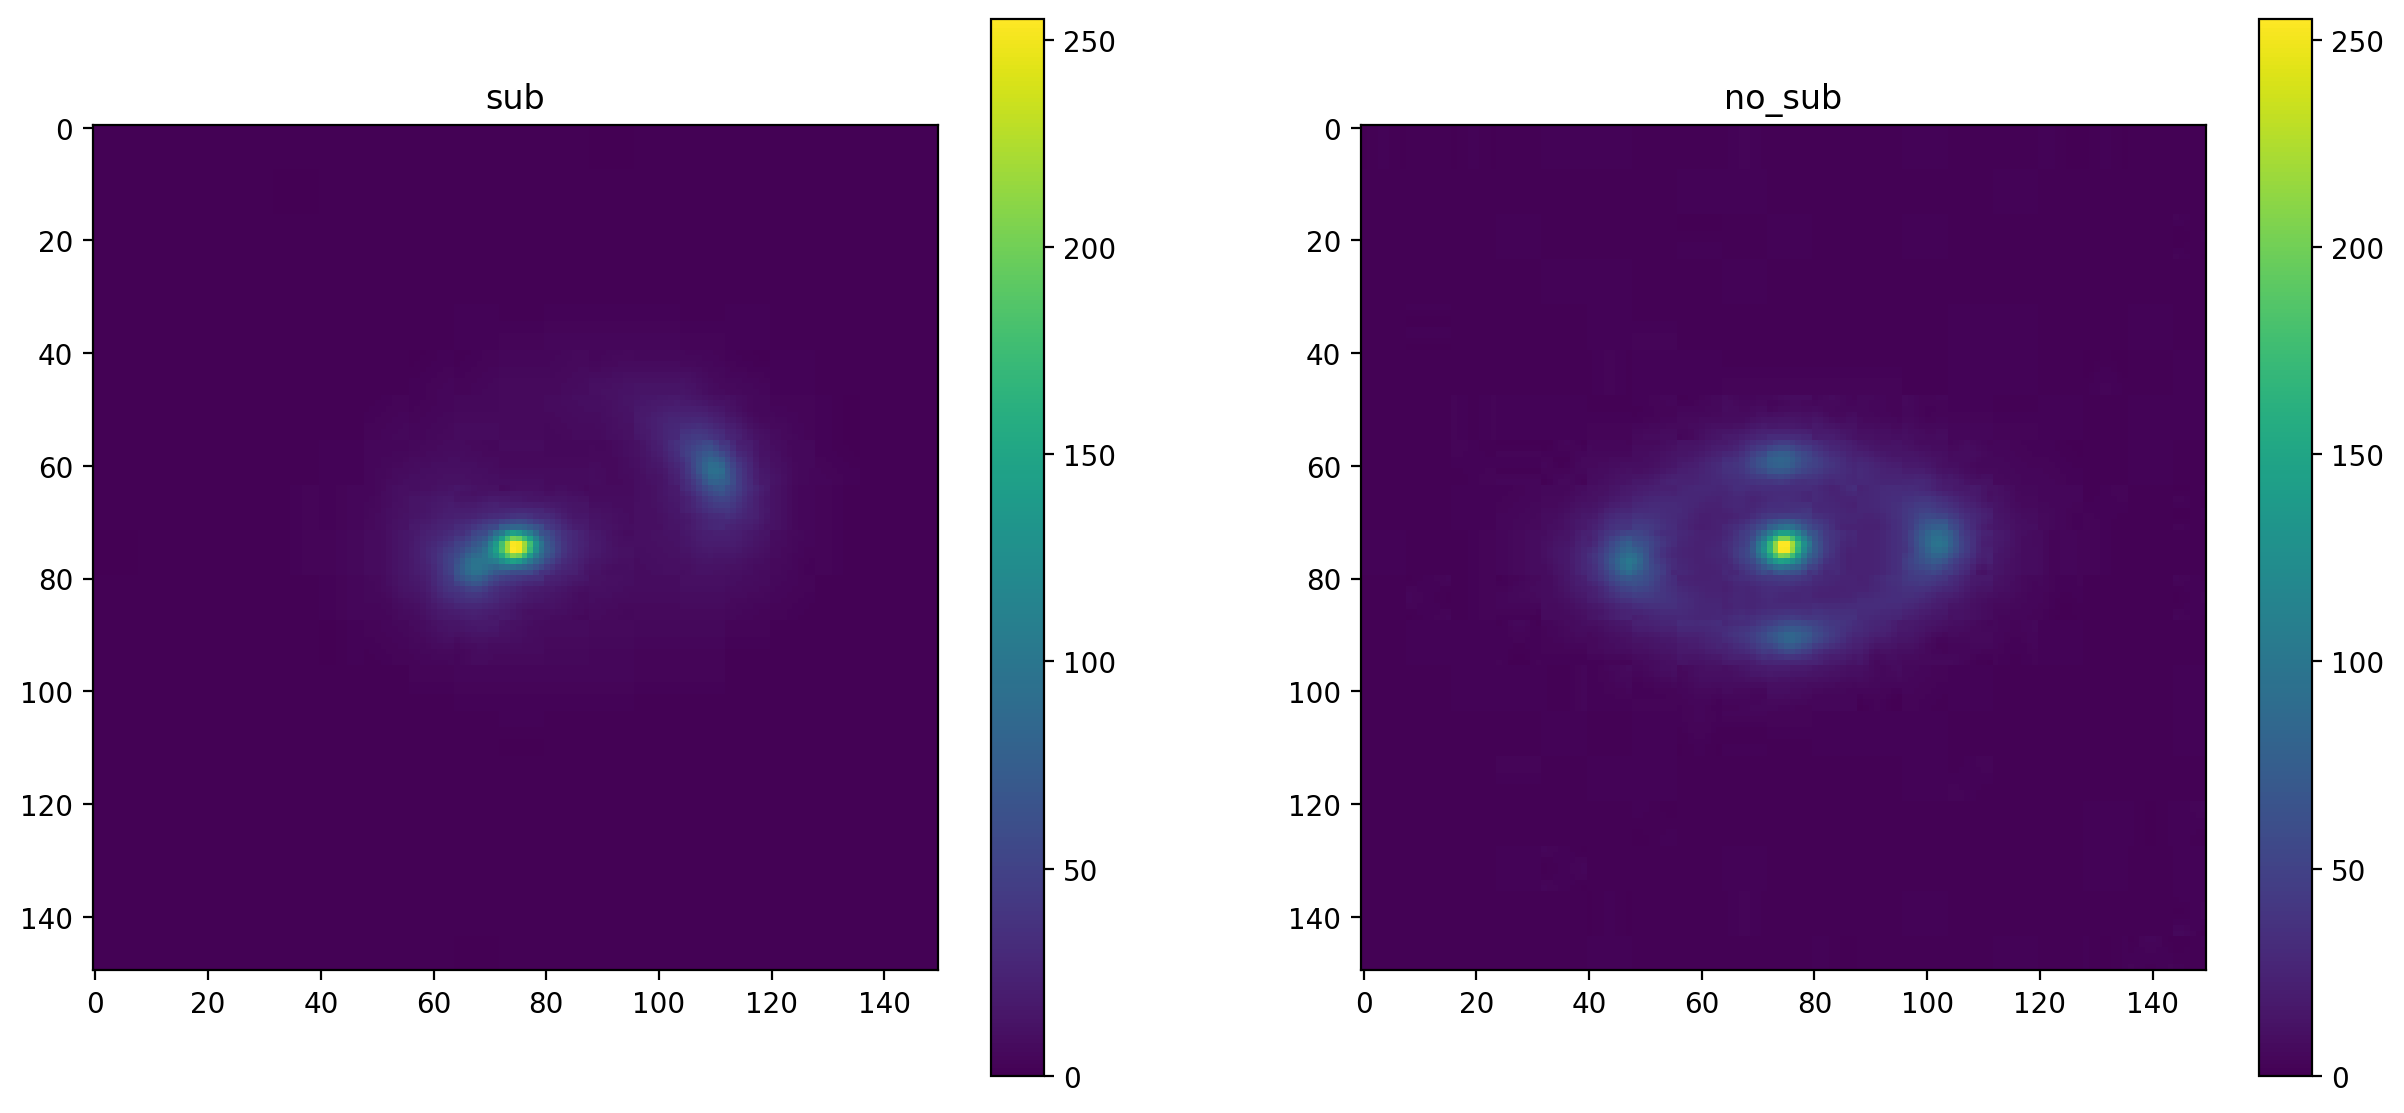

In [7]:
sub_dir = os.path.join(lens_dir, 'sub')
no_sub_dir = os.path.join(lens_dir, 'no_sub')

# pick random images to plot
sub_img = PIL.Image.open(os.path.join(sub_dir,'image_100015241301657914033614173596761104525.jpg'))
no_sub_img = PIL.Image.open(os.path.join(no_sub_dir,'image_97223362218452437755314224058973719256.jpg'))

fig, axs = plt.subplots(1, 2, figsize=(15,7), dpi=200)
im1 = axs[0].imshow(sub_img)
axs[0].set_title('sub')
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(no_sub_img)
axs[1].set_title('no_sub')
plt.colorbar(im2, ax=axs[1])
plt.show()

We can also check some characteristics of the images:

In [8]:
print(sub_img.getextrema())
print(sub_img.size)

(0, 255)
(150, 150)


<a id='oneone'></a>

## 1.1 Creating ways to interact with the data

Now we're concerned with creating a way that'll make it possible for our AAE to retrieve this data and use it for both training and testing (inference).

Since our images are neatly packed in sub-directories, I'll make use of PyTorch's `ImageFolder` to create a dataset that contains all images and their labels:

In [9]:
dataset = ImageFolder(lens_dir)

We can then check how many images are in each category:

In [10]:
np.unique(dataset.targets, return_counts=True)

(array([0, 1]), array([5000, 5000]))

And notice that they're very well distributed!

We can then make a map between the label index and the actual label class:
- `no_sub` = 0
- `sub` = 1

In [11]:
print(dataset.class_to_idx)

{'no_sub': 0, 'sub': 1}


The next step is to create a more elaborate dataset that lets us apply transforms to the data, return individual items and create a `DataLoader` from it:

In [12]:
class LensDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):            
        data = self.transform(dataset[idx][0])
        label = dataset[idx][1]        
        
        return data, label

    def __len__(self):
        return len(self.dataset)

The usage of `LensDataset` makes it really easy to apply transformations to the images. This will let us prepare the images neatly for our AAE while also letting us use data augmentation, something especially useful given the not so large amount of data that we have available.

In the following cell we define the types of transforms that we'll be using:

In [13]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomRotation(5),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.Resize((150, 150)),
                                      #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                      transforms.Grayscale(num_output_channels=1)
                                      ])

eval_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((150, 150)),
                                     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                     transforms.Grayscale(num_output_channels=1)
                                     ])

<a id='onetwo'></a>

## 1.2 Preparing the data for training/testing

In the evaluation test we were supposed to split the data so that 90% of it was used for training and 10% of it was used for testing, so I will follow these proportions. I'll also create a validation set that is 10% of the data (you can think of it as being part of the training set's 90%):

In [14]:
train_dataset = LensDataset(dataset, train_transform)
val_dataset = LensDataset(dataset, eval_transform)
test_dataset = LensDataset(dataset, eval_transform)

In [15]:
train_size = 0.8

num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))
split2 = int(np.floor((train_size+(1-train_size)/2) * num_train))
np.random.shuffle(indices)
train_idx, valid_idx, test_idx = indices[:split], indices[split:split2], indices[split2:]

train_data = Subset(train_dataset, indices=train_idx)
val_data = Subset(val_dataset, indices=valid_idx)
test_data = Subset(test_dataset, indices=test_idx)

train_data = Subset(train_dataset, indices=train_idx)
val_data = Subset(val_dataset, indices=valid_idx)
test_data = Subset(test_dataset, indices=test_idx)

We can check if our data was split correctly:

In [16]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

8000
1000
1000


Since we're training an anomaly detector, we want to detect one class as an anomaly. In our case, this will be the `sub` class. If we were to make our dataset be composed of both `sub` and `no_sub`, both would have a similar distribution and we wouldn't be able to tell them apart. This mistake can be seen quite clearly from my original submission [here](https://github.com/zysymu/ml4sci/blob/main/domain_adaptation/domain_adaptation.ipynb).

So in the next step we'll remove the `sub` images from the training dataset:

In [17]:
no_sub_idx = []

for i, (data, label) in enumerate(train_data):
    if label == 0:
        no_sub_idx.append(i)

no_sub_idx = np.array(train_data.indices)[no_sub_idx]
train_data_no_sub = Subset(train_dataset, no_sub_idx)

In [18]:
len(train_data_no_sub)

4020

We still have a good amount of images! Just to double-check and make sure that we removed all of the `sub` images:

In [19]:
for data, label in train_data_no_sub:
    if label != 0:
        print('NOT OK', label)

We can then create three `DataLoader`s, which will be used for training and testing. The `batch_size` is arbitrarily chosen to be 64:

In [20]:
train_dataloader = DataLoader(train_data_no_sub, shuffle=True, batch_size=64, num_workers=8)
val_dataloader = DataLoader(val_data, shuffle=True, batch_size=64, num_workers=2)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=64, num_workers=2)

Just to be sure that the data is homogenous across the training and testing samples, we print the first few labels of `test_dataloader`:

In [21]:
for i, (_, labels) in enumerate(test_dataloader):
    print(labels)
    break

tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])


<a id='two'></a>

# 2. The Adversarial Autoencoder (AAE)

<a id='twozero'></a>

## 2.0 Defining the AAE architecture

The structure of the AAE can be seen in the following picture, taken from [here](https://arxiv.org/pdf/1511.05644.pdf):

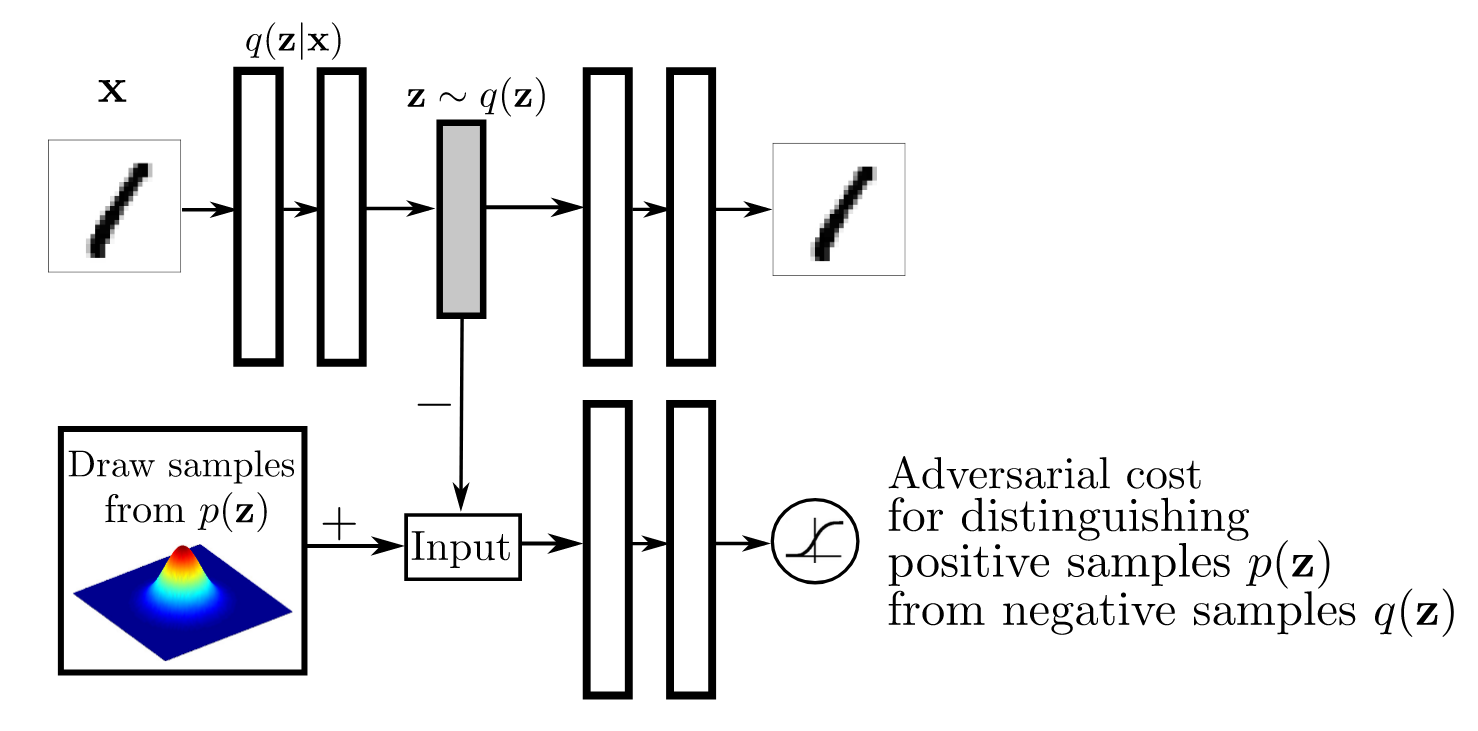



We have three main components: the `Encoder` ($q(z|x)$), the `Decoder` (upper right) and the `Discriminator` (bottom row).

The encoder receives as input an image $x$ and creates a latent representation of it, with smaller dimensions, similar to a compression operation. In our case, the input image $x$ has size 150x150x3, and it is transformed to a latent vector of size 1000x1x1: this is 67.5 times less information than the original image!!!

The decoder's job is to take this latent representation and reconstruct the input. Ideally, this reconstruction would be as close as possible to the input image $x$.

We want to create a latent space that follows a certain distriibution $p(z)$. so that we can generate new inputs without nedding to give the actual images. This makes it possible to "travel" around the latent space, exploring what's between the images that we used for training.

To do this, we make use of the discriminator. It is important to note that if we want to create a distribution for our latent space, we must teach the model to encode images according to this distribution. So we draw samples from our ideal ("real") distribution, which in our case is a simple Gaussian, and compare it with the latent vector of the image. The discriminator identifies which distribution is real and which is fake (random distribution that our encoder generated). From this, we can update the encoder to create vectors that follow our ideal distribution.

We'll be using the AAE as defined by the DeepLense evaluation test, copying the contents of the `AAE_Network_Architecture.py` file. This will enable us to use the pre-trained weights that were given by the evaluation test.

In [22]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 7, stride=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 7, stride=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 7)
        self.flat = nn.Flatten()
        self.linear = nn.Linear(5184, 1000)

    def forward(self, x):
        convolution1 = F.relu(self.conv1(x))
        convolution2 = F.relu(self.conv2(convolution1))
        convolution3 = F.relu(self.conv3(convolution2))
        Flattened = self.flat(convolution3)
        z = self.linear(Flattened)

        return z

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Linear(1000, 5184)
        self.conv4 = nn.ConvTranspose2d(64, 32, 7)
        self.conv5 = nn.ConvTranspose2d(32, 16, 7, stride=3, padding=1, output_padding=2)
        self.conv6 = nn.ConvTranspose2d(16, 1, 6, stride=3, padding=1, output_padding=2)

    def forward(self, x):
        hidden = self.linear(x)
        Reshaped = hidden.reshape(-1,64,9,9)
        convolution4 = F.relu(self.conv4(Reshaped))
        convolution5 = F.relu(self.conv5(convolution4))
        predicted = torch.tanh(self.conv6(convolution5))

        return predicted

class Discriminator(nn.Module):
    def __init__(self, dim_z=1000 , dim_h=256):
        super(Discriminator,self).__init__()
        
        self.dim_z = dim_z
        self.dim_h = dim_h
        self.network = []
        self.network.extend([
            nn.Linear(self.dim_z, self.dim_h),
            nn.ReLU(),
            nn.Linear(self.dim_h, self.dim_h),
            nn.ReLU(),
            nn.Linear(self.dim_h,1),
            nn.Sigmoid(),
        ])
        self.network = nn.Sequential(*self.network)

    def forward(self, z):
        disc = self.network(z)

        return disc

The distribution that we want our AAE to follow is arbitrary and it's definetely worth checking out different distributions in order to find the best one for the problem at hand. For simplicity sake we're going to use a simple gaussian distribution that can be seen in many different AAE implementations:

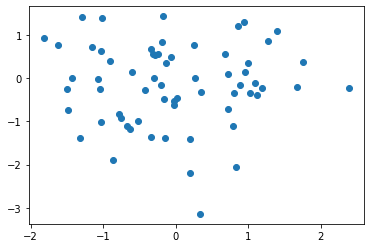

In [23]:
z_distribution = torch.randn(64, 1000)
plt.scatter(z_distribution[:,0], z_distribution[:,1])
plt.show()

Here $64$ represents the batch size, which is a hyperparameter and $1000$ is the size of our latent vector. This is made more easily understandable while looking at the training loops.

<a id='twoone'></a>

## 2.1 Creating a way to load the model

We'll start off by defining the device that we'll use:

In [24]:
global device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

We can then create a function that loads the model:

In [25]:
def load_model():
    """
    Loads the model
    """
    encoder = Encoder()
    decoder = Decoder()
    discriminator = Discriminator()

    encoder = encoder.to(device)
    decoder = decoder.to(device)
    discriminator = discriminator.to(device)

    return encoder, decoder, discriminator

We'll also define a function that enables us to load the pre-trained model:

In [26]:
def load_model_pretrained(encoder_model, decoder_model, discriminator_model):
    """
    Loads the model by being given the path to the architecture + weights of each network
    """
    encoder = Encoder()
    decoder = Decoder()
    discriminator = Discriminator()

    encoder = torch.load(encoder_model, map_location=device)
    decoder = torch.load(decoder_model, map_location=device)
    discriminator = torch.load(discriminator_model, map_location=device)

    encoder = encoder.to(device)
    decoder = decoder.to(device)
    discriminator = discriminator.to(device)

    return encoder, decoder, discriminator

Finally, we'll also define a function that enables us to load the model (using `state_dict`s, the recommended way of saving model weights in PyTorch) and its history:

In [27]:
def load_weights_and_history(save_path):
    """
    Loads the model weights and history
    """
    s = torch.load(save_path, map_location=device)

    history = s['history']

    encoder = Encoder()
    decoder = Decoder()
    discriminator = Discriminator()

    encoder.load_state_dict(s['encoder_weights'])
    decoder.load_state_dict(s['decoder_weights'])
    discriminator.load_state_dict(s['discriminator_weights'])

    encoder = encoder.to(device)
    decoder = decoder.to(device)
    discriminator = discriminator.to(device)

    return encoder, decoder, discriminator, history

<a id='twotwo'></a>

## 2.2 Creating the training loop

Now that we can access the model, we'll define a function that enables us to train it:

In [28]:
def train_model(encoder, decoder, discriminator, train_dataloader, epochs, save_path, viz=False):
    """
    Train the AAE.

    Inputs:
    -------
    encoder: the encoder model.
    
    decoder: the decoder model.
    
    discriminator: the discriminator model.

    train_dataloader: a `DataLoader` based on a `LensDataset`.

    epochs: number of epochs to train on (int).

    save_path: path to save the model's weights and history (str).

    viz: if `True`, after each epoch a original image - reconstructed image pair will be plotted
    """
    # --- HYPERPARAMETERS --- (these could be function arguments, but for simplicity sake we'll make them fixed)
    # reconstruction phase:
    reconstruction_criterion = nn.MSELoss()
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-4)

    # regularization phase:
    def discriminator_criterion(input, target, epsilon):
        return -torch.mean(torch.log(target + epsilon) + torch.log(1 - input + epsilon))

    def generator_criterion(input, epsilon):
        return -torch.mean(torch.log(input + epsilon))

    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4)
    generator_optimizer = optim.Adam(encoder.parameters(), lr=1e-5)

    # set learning rate schedulers (a more thorough analysis of this would be really useful!)
    # as of now i'm using default parameters to all optimizers
    encoder_scheduler = lr_scheduler.StepLR(encoder_optimizer, step_size=7, gamma=0.1)
    decoder_scheduler = lr_scheduler.StepLR(decoder_optimizer, step_size=7, gamma=0.1)
    discriminator_scheduler = lr_scheduler.StepLR(discriminator_optimizer, step_size=7, gamma=0.1)
    generator_scheduler = lr_scheduler.StepLR(generator_optimizer, step_size=7, gamma=0.1)

    # --- HISOTRY ---
    history = {'reconstruction_losses': [],
                'discriminator_losses': [],
                'generator_losses': []}

    # --- TRAINING LOOP ---
    epsilon = 1e-15 # prevents the loss from getting to zero

    reconstruction_losses = []
    discriminator_losses = []
    generator_losses = []

    for epoch in range(epochs):
        decoder.train()
        encoder.train()
        discriminator.train()

        running_reconstruction_loss = 0.0
        running_discriminator_loss = 0.0
        running_generator_loss = 0.0

        loop = tqdm(train_dataloader, total=len(train_dataloader), position=0, leave=True)
        for data, label in loop:
            data = data.to(device)

            # zero the gradients
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            discriminator_optimizer.zero_grad()
            generator_optimizer.zero_grad()

            # RECONSTRUCTION PHASE
            # pass data through the autoencoder
            z_sample = encoder(data)
            x_sample = decoder(z_sample)

            # compute the loss
            reconstruction_loss = reconstruction_criterion(input=x_sample, target=data)
                
            # backpropagate and update weights
            reconstruction_loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()

            # REGULARIZATION PHASE - DISCRIMINATOR
            encoder.eval()
                
            # generate target latent space data according to a gaussian distribution
            z_real_gauss = Variable(torch.randn(data.size(0), 1000)) # 1000 fixed cuz its the encoder's input size
            z_real_gauss = z_real_gauss.to(device) # what we want
            z_fake_gauss = encoder(data) # what we currently have

            # determine discriminator classification of both samples
            d_real_gauss = discriminator(z_real_gauss) # real sampled gaussian 
            d_fake_gauss = discriminator(z_fake_gauss) # fake created gaussian

            # compute the loss
            discriminator_loss = discriminator_criterion(input=d_fake_gauss, target=d_real_gauss, epsilon=epsilon)
                
            # backpropagate and update weights
            discriminator_loss.backward()
            discriminator_optimizer.step()

            # REGULARIZATION PHASE - GENERATOR
            encoder.train()

            z_fake_gauss = encoder(data)
            d_fake_gauss = discriminator(z_fake_gauss)
                
            # compute the loss
            generator_loss = generator_criterion(input=d_fake_gauss, epsilon=epsilon)

            # backpropagate and update weights
            generator_loss.backward()
            generator_optimizer.step()

            # METRICS
            running_reconstruction_loss += reconstruction_loss.item()
            running_discriminator_loss += discriminator_loss.item()
            running_generator_loss += generator_loss.item()

            loop.set_description(f'Epoch {epoch+1}/{epochs}')

        # save metrics
        epoch_reconstruction_loss = running_reconstruction_loss / len(train_dataloader.dataset)
        epoch_discriminator_loss = running_discriminator_loss / len(train_dataloader.dataset)
        epoch_generator_loss = running_generator_loss / len(train_dataloader.dataset)

        reconstruction_losses.append(epoch_reconstruction_loss)
        discriminator_losses.append(epoch_discriminator_loss)
        generator_losses.append(epoch_generator_loss)

        # visualize the reconstruction
        if viz:
            fig, axs = plt.subplots(1,2)
            axs[0].imshow(data[0,0].detach().cpu().numpy())
            axs[1].imshow(x_sample[0,0].detach().cpu().numpy())
            plt.show()

        print(f'\n[Epoch {epoch+1}/{epochs}]', 'reconstruction loss: {:.4f}; discriminator loss: {:.4f}; generator loss: {:.4f}'.format(epoch_reconstruction_loss, epoch_discriminator_loss, epoch_generator_loss))

        # learning rate scheduler
        encoder_scheduler.step()
        decoder_scheduler.step()
        discriminator_scheduler.step()
        generator_scheduler.step()

    history['reconstruction_losses'] = reconstruction_losses
    history['discriminator_losses'] = discriminator_losses
    history['generator_losses'] = generator_losses

    torch.save({'encoder_weights': encoder.state_dict(),
                'decoder_weights': decoder.state_dict(),
                'discriminator_weights': discriminator.state_dict(),
                'history': history}, save_path)
        
    return encoder, decoder, discriminator, history

<a id='twothree'></a>

## 2.3 Defining a way to visualize the metrics

We'll define a function that enables us to visualize the model's training metrics:

In [29]:
def metrics(history):
    """
    Plot the three metrics that are tracked during training.
    """
    fig, axs = plt.subplots(1, 3, figsize=(18,5), dpi=200)

    epochs = len(history['reconstruction_losses'])

    axs[0].plot(range(1, epochs+1), history['reconstruction_losses'])
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Reconstruction loss')
    axs[0].set_title('Reconstruction loss')

    axs[1].plot(range(1, epochs+1), history['discriminator_losses'])
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Discriminator loss')
    axs[1].set_title('Discriminator loss')

    axs[2].plot(range(1, epochs+1), history['generator_losses'])
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Generator loss')
    axs[2].set_title('Generator loss')      
        
    plt.show()

<a id='twofour'></a>

## 2.4 Defining a way to evaluate the model

The method that we'll use to evaluate the model was inspired heavily by [this](https://arxiv.org/pdf/1902.06924.pdf) paper. I apply a simple mean squared error comparing the original image to the generated one. This outputs an anomaly score. If the anomaly score is above a certain threshold, the image is considered an anomaly (`sub`).

It is important to note that in the paper the authors mention applying the discriminator on the encoded data and using its output as an anomaly score. I didn't apply this method because it didn't seem to output good results for me, but more systematic tests could check if this is indeed the case.

First we must find a good value for the threshold. In my original submission I found a value from the test set. This would **not** be useful in a real life situation and would really damage the model's predictions. For this reason, we'll use the validation set to find this threshold. This makes sure that we don't influence our classifier with the test data.

The following code is heavily based in [this](https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098) article and suggestions by one of the mentors:

In [30]:
def find_thresh(encoder, decoder, discriminator, val_dataloader, viz=False):
    encoder.eval()
    decoder.eval()

    errors_plot = {0:[], 1:[]}
    anomaly_scores = []
    labels = []

    mse = nn.MSELoss()

    loop = tqdm(val_dataloader, total=len(val_dataloader), position=0, leave=True)
    for data, label in loop:
        data = data.to(device)

        encoded = encoder(data)
        decoded = decoder(encoded)

        for i in range (data.size(0)):
            anomaly_score = mse(data[i], decoded[i])
            anomaly_scores.append(anomaly_score.item())
            labels.append(label[i])

            if viz == True:
                if label[i] == 0:
                    errors_plot[0].append(anomaly_score.item())
                else:
                    errors_plot[1].append(anomaly_score.item())

    precision, recall, thresholds = precision_recall_curve(labels, anomaly_scores)
    precision = precision[1:]
    recall = recall[1:]

    # calculate the intercept between precision and recall to find best trade-off
    # from https://stackoverflow.com/questions/3252194/numpy-and-line-intersections
    thresh = interp1d(precision - recall, thresholds)(0)
    pr_intersect = interp1d(thresholds, precision)(thresh)

    if viz == True:
        # precision recall
        plt.figure(figsize=(6,6), dpi=200)
        plt.plot(thresholds, precision, label='precision')
        plt.plot(thresholds, recall, label='recall')
        plt.scatter(thresh, pr_intersect, marker='*', c='black', label='thresh')
        plt.ylabel('Precision/Recall')
        plt.xlabel('Threshold')
        plt.legend()
        plt.show()

        # anomaly score histogram
        plt.figure(figsize=(6,6), dpi=200)
        plt.hist(errors_plot[0], bins=100, color='b', alpha=.5, label='0')
        plt.hist(errors_plot[1], bins=100, color='r', alpha=.5, label='1')
        plt.axvline(thresh, linestyle='--', c='black', label='thresh')
        plt.ylabel('Density')
        plt.xlabel('Anomaly score')
        plt.legend()
        plt.show()

        # ROC
        plt.figure(figsize=(6,6), dpi=200)
        fp, tp, _ = roc_curve(labels, anomaly_scores)
        auroc = auc(fp, tp)

        auroc = float('{:.2f}'.format(auroc))
        n = f'auroc = {auroc}'

        plt.plot(fp, tp, label=n)
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.xlabel('False Positives')
        plt.ylabel('True Positives')
        ax = plt.gca()
        ax.set_aspect('equal')
        plt.legend()
        plt.show()

    return thresh.item()

Another point to keep in mind is that in order to find the best threshold I get the intercept between precision and recall. This could, of course, be tuned so that we prioritize one over the other.

Now we'll define a function that enables us to compare the labels assigned to images by the model with the images real labels. This lets us see how accurate the model was:

In [31]:
def evaluate(encoder, decoder, discriminator, test_dataloader, thresh):
    """
    Use the AAE for inference over the `test_dataloader` data. A label is assigned 
    depending on whether the anomaly_score, defined as the error between the original
    image and its reconstruction, is above or below `thresh`.

    Inputs:
    -------
    test_dataloader: a `DataLoader` based on a `LensDataset`

    thresh: a number that defines the label of an input image according to the error
    between the original image and its reconstruction. If error > thresh, label = 1; 
    if error <= thresh, label = 0 (float)
    """
    encoder.eval()
    decoder.eval()

    mse = nn.MSELoss()
    true_labels = []
    predictions = []
        
    loop = tqdm(test_dataloader, total=len(test_dataloader), position=0, leave=True)
    for data, label in loop:
        data = data.to(device)
        label = label.to(device)

        encoded = encoder(data)
        decoded = decoder(encoded)

        for i in range (data.size(0)):
            anomaly_score = mse(data[i], decoded[i])

            pred = int(anomaly_score > thresh)

            true_labels.append(label[i].item())
            predictions.append(pred)

    # plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['({0:.2%})'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    tn, fp, fn, tp = cm.ravel()

    plt.figure(figsize=(5,5), dpi=200)
    sns.heatmap(cm, annot=labels, fmt="")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

<a id='three'></a>

# 3. Training the AAE from scratch

<a id='threezero'></a>

## 3.0 Training the model 

We can first visualize how the model is performing without any training. To do this we'll load the model:

In [32]:
encoder_scratch, decoder_scratch, discriminator_scratch = load_model()

And try to reconstruct a random image: (left: original image; right: reconstructed image)

tensor(0)


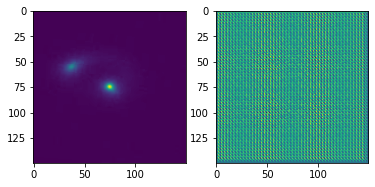

In [33]:
for data, label in train_dataloader:
    data = data.to(device)

    z_sample = encoder_scratch(data)
    x_sample = decoder_scratch(z_sample)

    print(label[0])
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(data[0,0].detach().cpu().numpy())
    axs[1].imshow(x_sample[0,0].detach().cpu().numpy())
    plt.show()
    
    break

We'll then train the AAE from the scratch (i.e. not using the pre-trained weights). We'll also be enabling `viz` in order to see the progress of the reconstruction:

Epoch 1/50: 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]


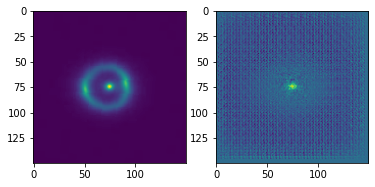

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 1/50] reconstruction loss: 0.0003; discriminator loss: 0.0133; generator loss: 0.0210


Epoch 2/50: 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


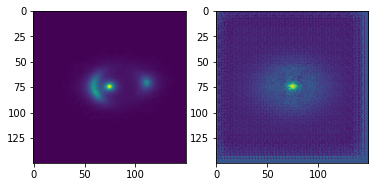

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 2/50] reconstruction loss: 0.0001; discriminator loss: 0.0020; generator loss: 0.0680


Epoch 3/50: 100%|██████████| 63/63 [00:19<00:00,  3.30it/s]


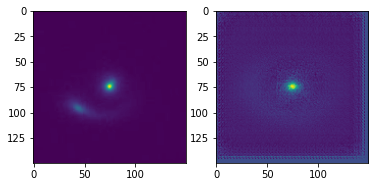

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 3/50] reconstruction loss: 0.0001; discriminator loss: 0.0006; generator loss: 0.0781


Epoch 4/50: 100%|██████████| 63/63 [00:19<00:00,  3.29it/s]


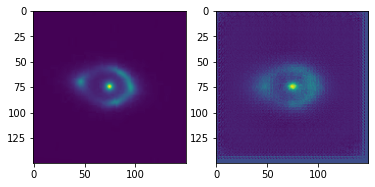

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 4/50] reconstruction loss: 0.0000; discriminator loss: 0.0003; generator loss: 0.0837


Epoch 5/50: 100%|██████████| 63/63 [00:18<00:00,  3.35it/s]


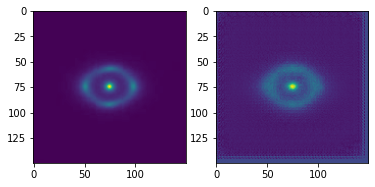

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 5/50] reconstruction loss: 0.0000; discriminator loss: 0.0002; generator loss: 0.0886


Epoch 6/50: 100%|██████████| 63/63 [00:18<00:00,  3.34it/s]


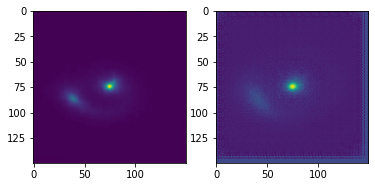

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 6/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.0921


Epoch 7/50: 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]


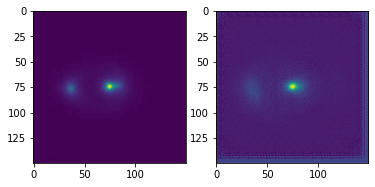

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 7/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.0945


Epoch 8/50: 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


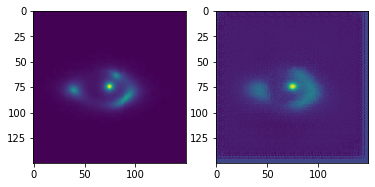

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 8/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.0908


Epoch 9/50: 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]


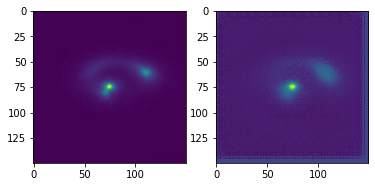

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 9/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.0927


Epoch 10/50: 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


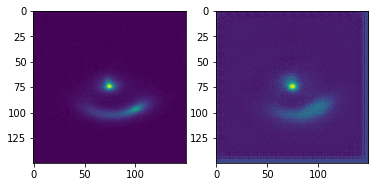

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 10/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.0945


Epoch 11/50: 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


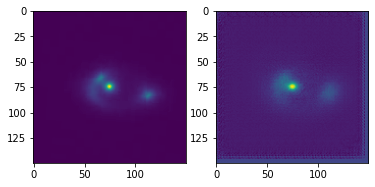

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 11/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.0963


Epoch 12/50: 100%|██████████| 63/63 [00:19<00:00,  3.23it/s]


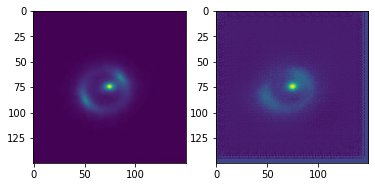

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 12/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.0979


Epoch 13/50: 100%|██████████| 63/63 [00:19<00:00,  3.18it/s]


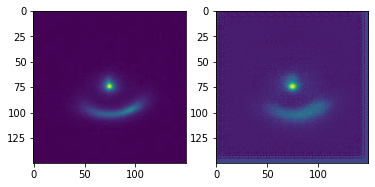

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 13/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.0994


Epoch 14/50: 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


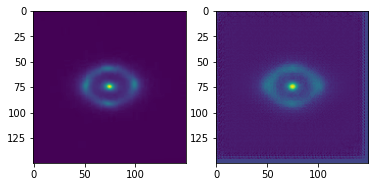

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 14/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1009


Epoch 15/50: 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]


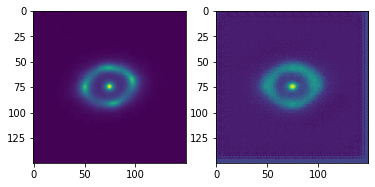

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 15/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1011


Epoch 16/50: 100%|██████████| 63/63 [00:19<00:00,  3.24it/s]


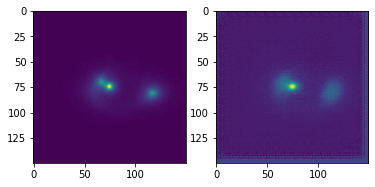

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 16/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1013


Epoch 17/50: 100%|██████████| 63/63 [00:19<00:00,  3.24it/s]


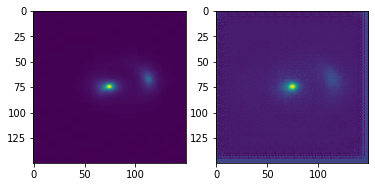

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 17/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1016


Epoch 18/50: 100%|██████████| 63/63 [00:19<00:00,  3.21it/s]


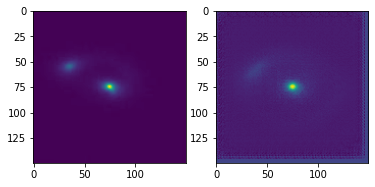

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 18/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1018


Epoch 19/50: 100%|██████████| 63/63 [00:19<00:00,  3.22it/s]


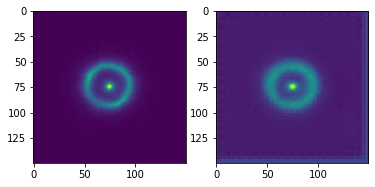

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 19/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1020


Epoch 20/50: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]


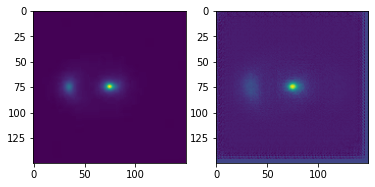

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 20/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1022


Epoch 21/50: 100%|██████████| 63/63 [00:20<00:00,  3.12it/s]


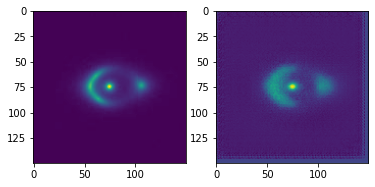

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 21/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1025


Epoch 22/50: 100%|██████████| 63/63 [00:19<00:00,  3.15it/s]


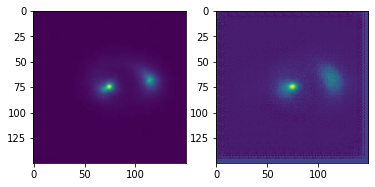

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 22/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1027


Epoch 23/50: 100%|██████████| 63/63 [00:20<00:00,  3.14it/s]


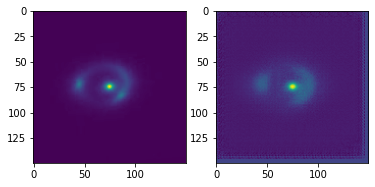

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 23/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1026


Epoch 24/50: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]


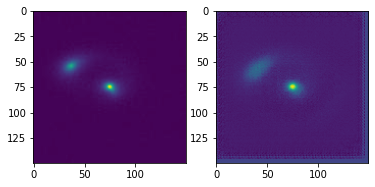

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 24/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1026


Epoch 25/50: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]


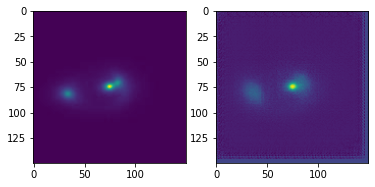

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 25/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1027


Epoch 26/50: 100%|██████████| 63/63 [00:20<00:00,  3.14it/s]


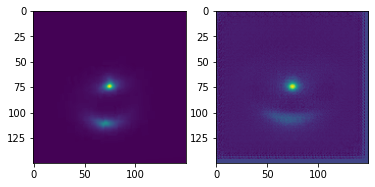

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 26/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1027


Epoch 27/50: 100%|██████████| 63/63 [00:19<00:00,  3.17it/s]


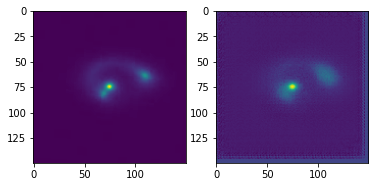

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 27/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 28/50: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]


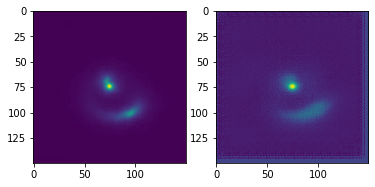

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 28/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 29/50: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]


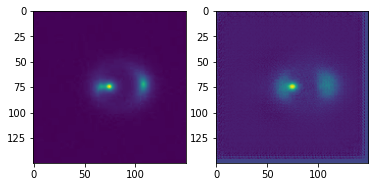

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 29/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1028


Epoch 30/50: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]


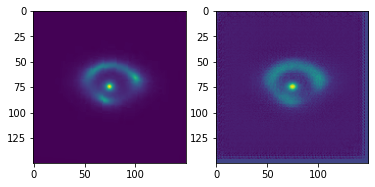

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 30/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 31/50: 100%|██████████| 63/63 [00:20<00:00,  3.12it/s]


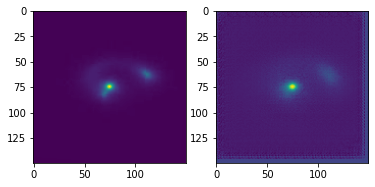

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 31/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 32/50: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]


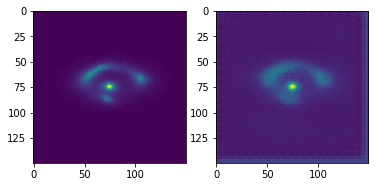

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 32/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 33/50: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]


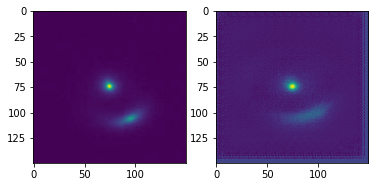

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 33/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 34/50: 100%|██████████| 63/63 [00:20<00:00,  3.05it/s]


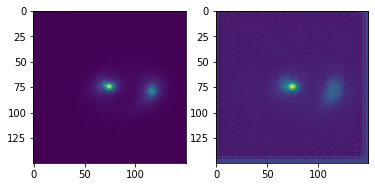

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 34/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 35/50: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]


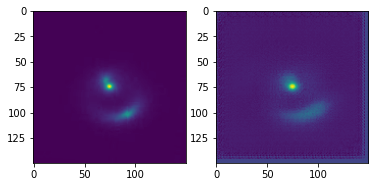

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 35/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 36/50: 100%|██████████| 63/63 [00:20<00:00,  3.06it/s]


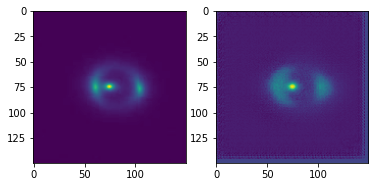

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 36/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 37/50: 100%|██████████| 63/63 [00:20<00:00,  3.03it/s]


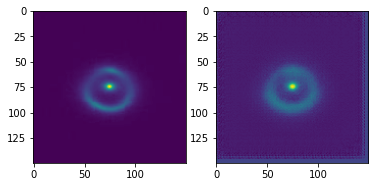

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 37/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 38/50: 100%|██████████| 63/63 [00:21<00:00,  2.97it/s]


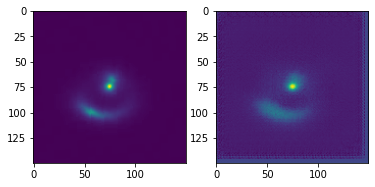

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 38/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 39/50: 100%|██████████| 63/63 [00:21<00:00,  2.95it/s]


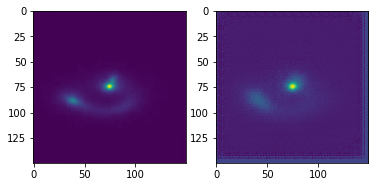

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 39/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 40/50: 100%|██████████| 63/63 [00:22<00:00,  2.84it/s]


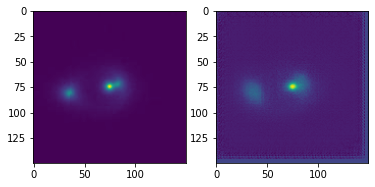

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 40/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 41/50: 100%|██████████| 63/63 [00:21<00:00,  2.89it/s]


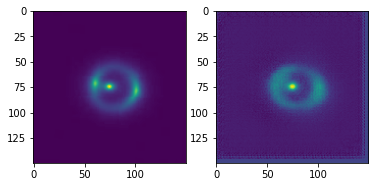

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 41/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 42/50: 100%|██████████| 63/63 [00:20<00:00,  3.00it/s]


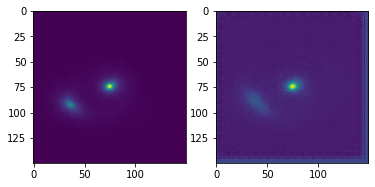

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 42/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 43/50: 100%|██████████| 63/63 [00:21<00:00,  2.98it/s]


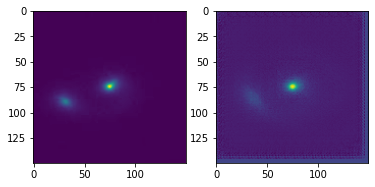

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 43/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 44/50: 100%|██████████| 63/63 [00:21<00:00,  2.92it/s]


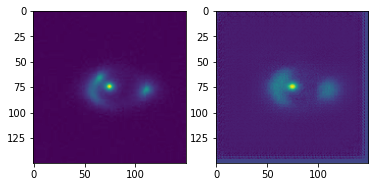

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 44/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 45/50: 100%|██████████| 63/63 [00:21<00:00,  2.93it/s]


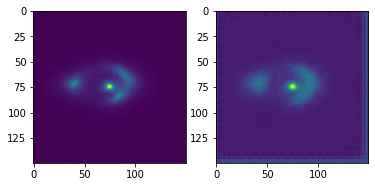

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 45/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 46/50: 100%|██████████| 63/63 [00:22<00:00,  2.75it/s]


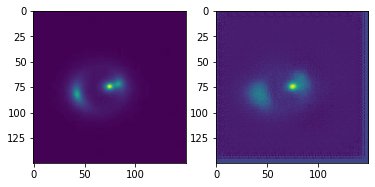

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 46/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 47/50: 100%|██████████| 63/63 [00:22<00:00,  2.78it/s]


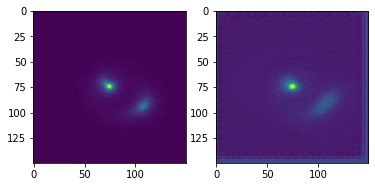

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 47/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 48/50: 100%|██████████| 63/63 [00:22<00:00,  2.83it/s]


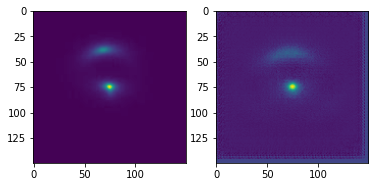

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 48/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 49/50: 100%|██████████| 63/63 [00:22<00:00,  2.80it/s]


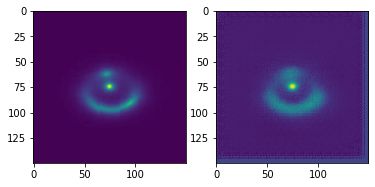

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 49/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


Epoch 50/50: 100%|██████████| 63/63 [00:22<00:00,  2.80it/s]


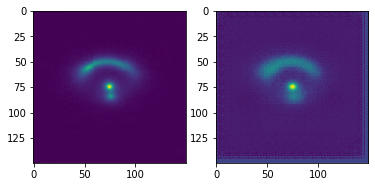


[Epoch 50/50] reconstruction loss: 0.0000; discriminator loss: 0.0001; generator loss: 0.1029


In [34]:
save_path_scratch = os.path.join('/content/drive/MyDrive/ml4sci/domain_adaptation/', 'weights_history_scratch.pt')

encoder_scratch, decoder_scratch, discriminator_scratch, history_scratch = train_model(encoder_scratch, decoder_scratch, discriminator_scratch, train_dataloader, 50, save_path_scratch, viz=True)

<a id='threeone'></a>

## 3.1 Visualizing the training metrics

We'll now load the model and the history and visualize the training metrics. Note that it isn't necessary to load the model and the training history since we already have it. But this could be useful in case the runtime crashes.

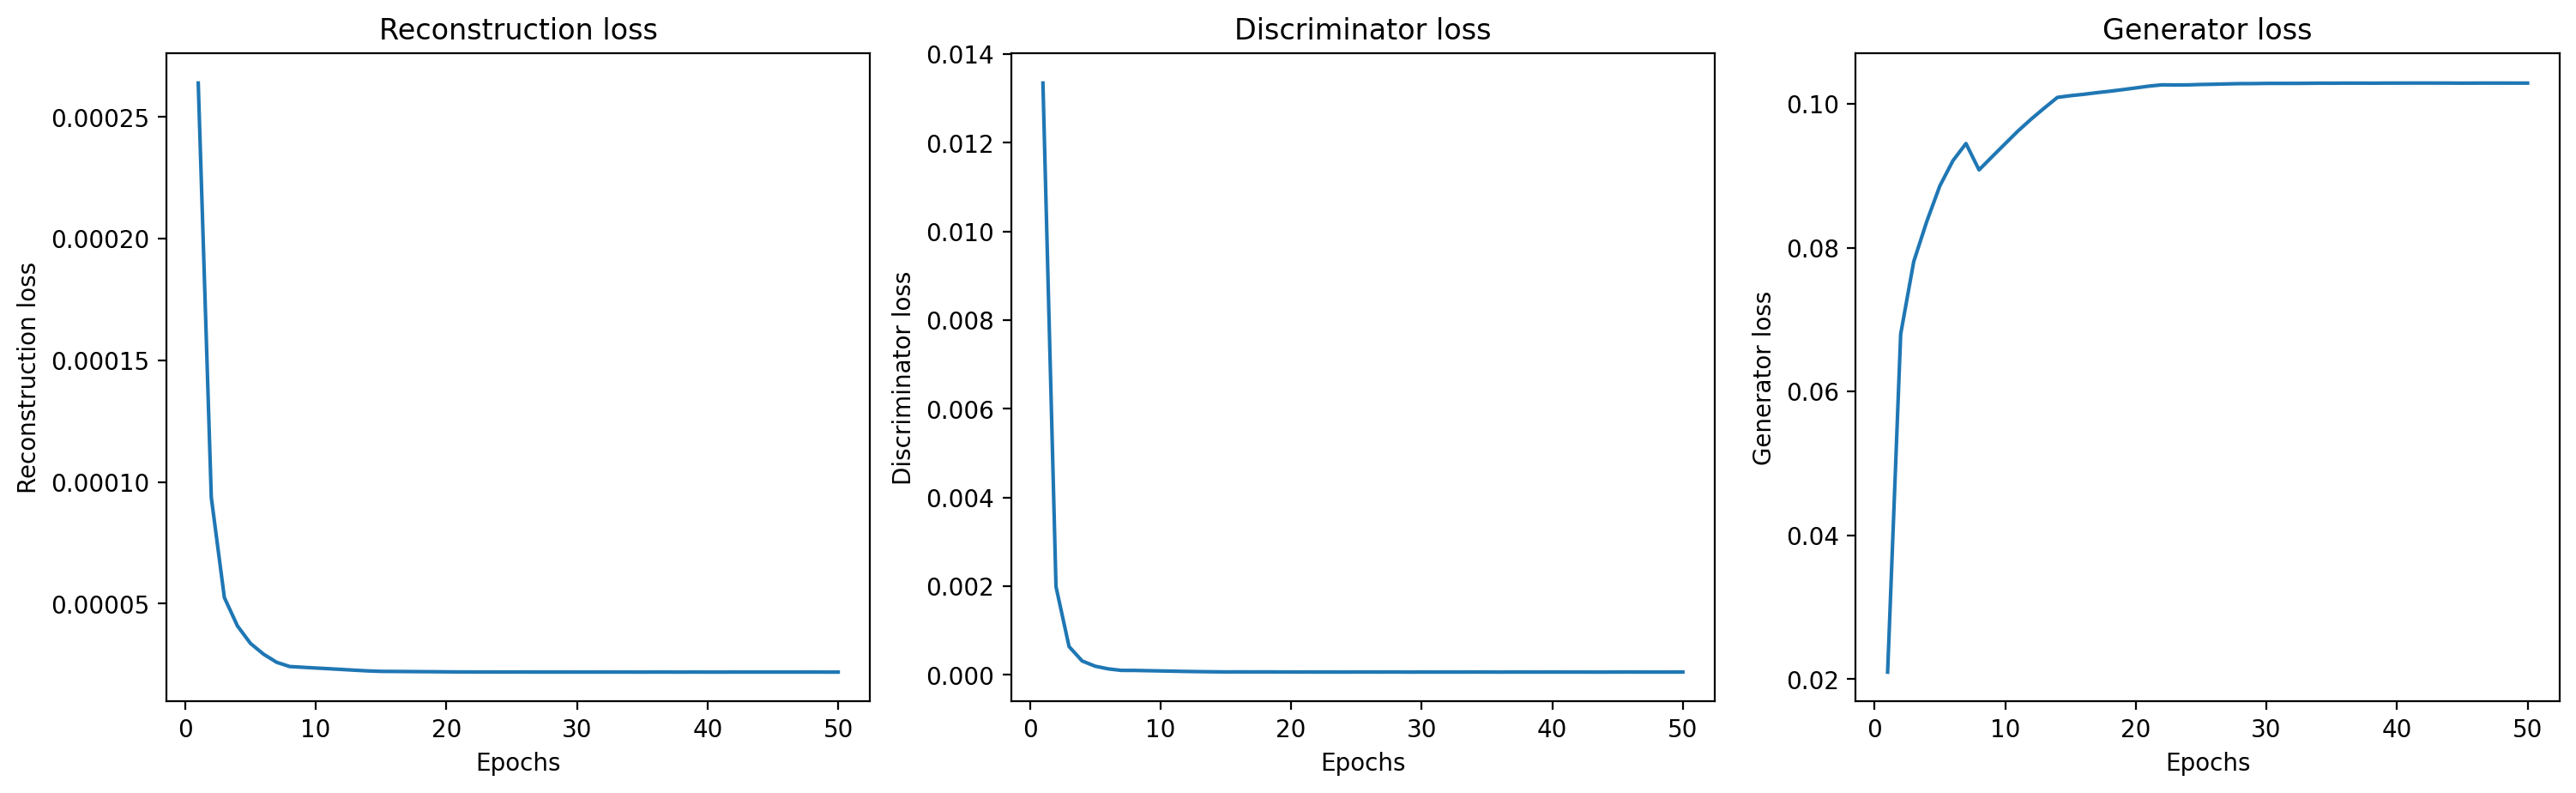

In [35]:
encoder_scratch, decoder_scratch, discriminator_scratch, history_scratch = load_weights_and_history(save_path_scratch)
metrics(history_scratch)

<a id='threetwo'></a>

## 3.2 Evaluating the model

Now, finally, we'll evaluate the model on the testing set that we defined earlier:

100%|██████████| 16/16 [02:23<00:00,  8.98s/it]


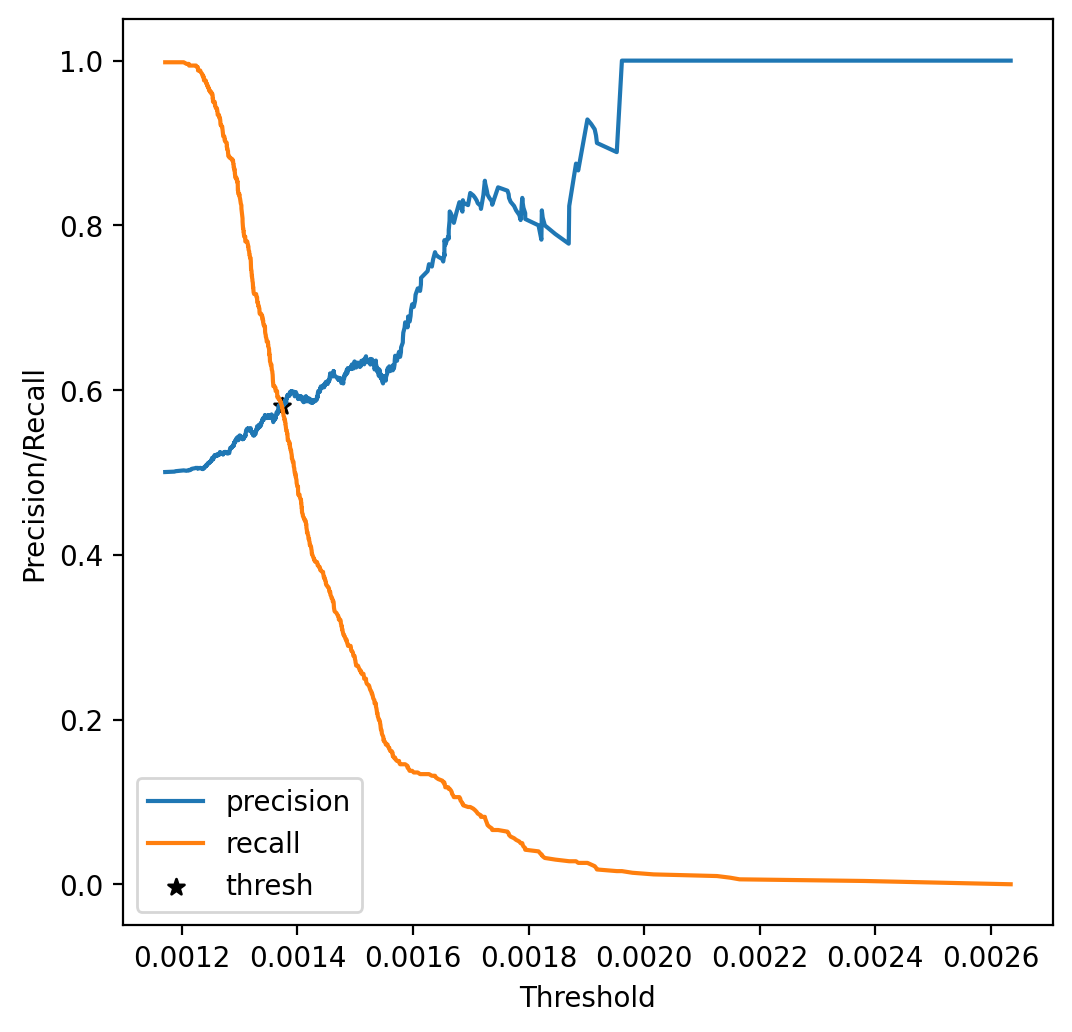

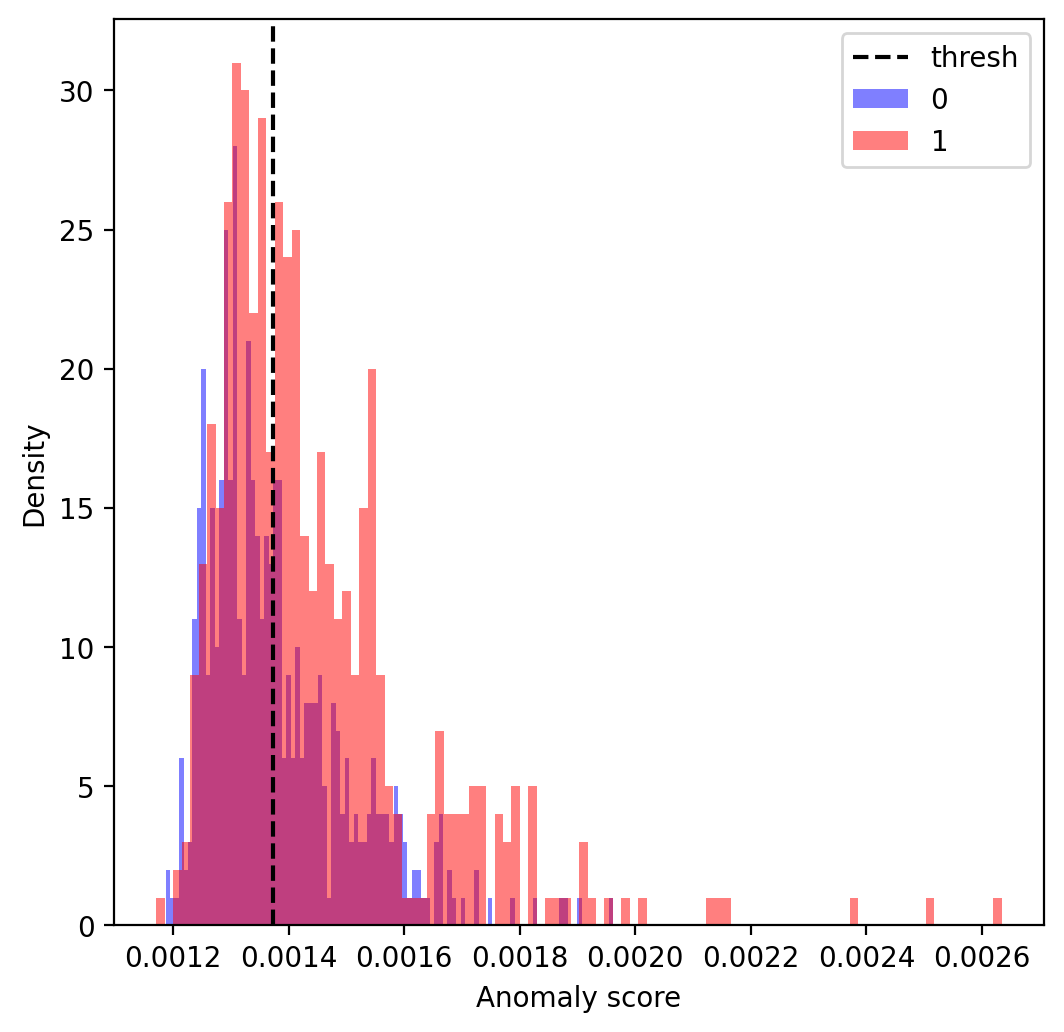

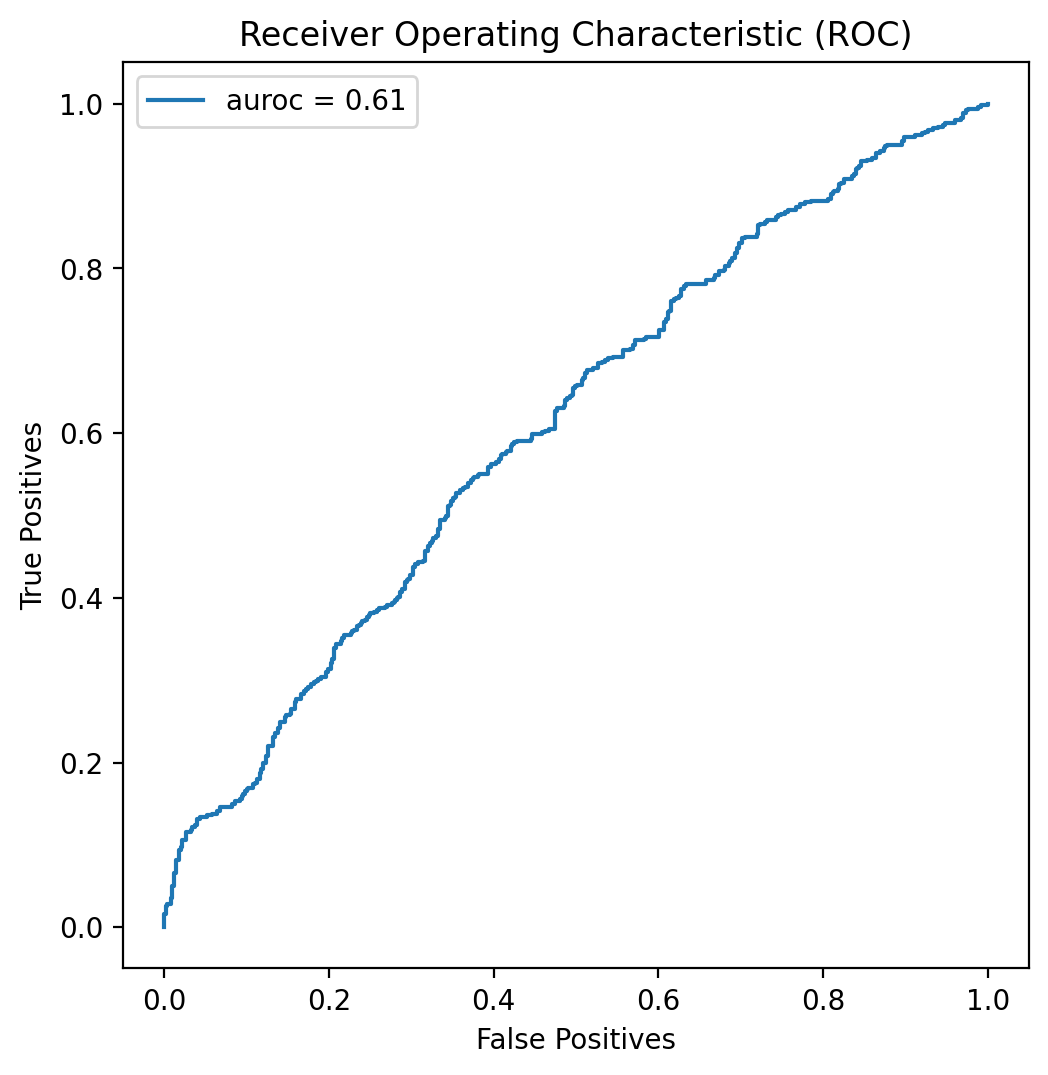

0.001372825470753014

In [36]:
thresh_scratch = find_thresh(encoder_scratch, decoder_scratch, discriminator_scratch, val_dataloader, viz=True)
thresh_scratch

We can see that in this the AAE wasn't able to really separate the distribution of the two labels, which results in a not so good result, as can be seen in the ROC.

100%|██████████| 16/16 [01:57<00:00,  7.37s/it]


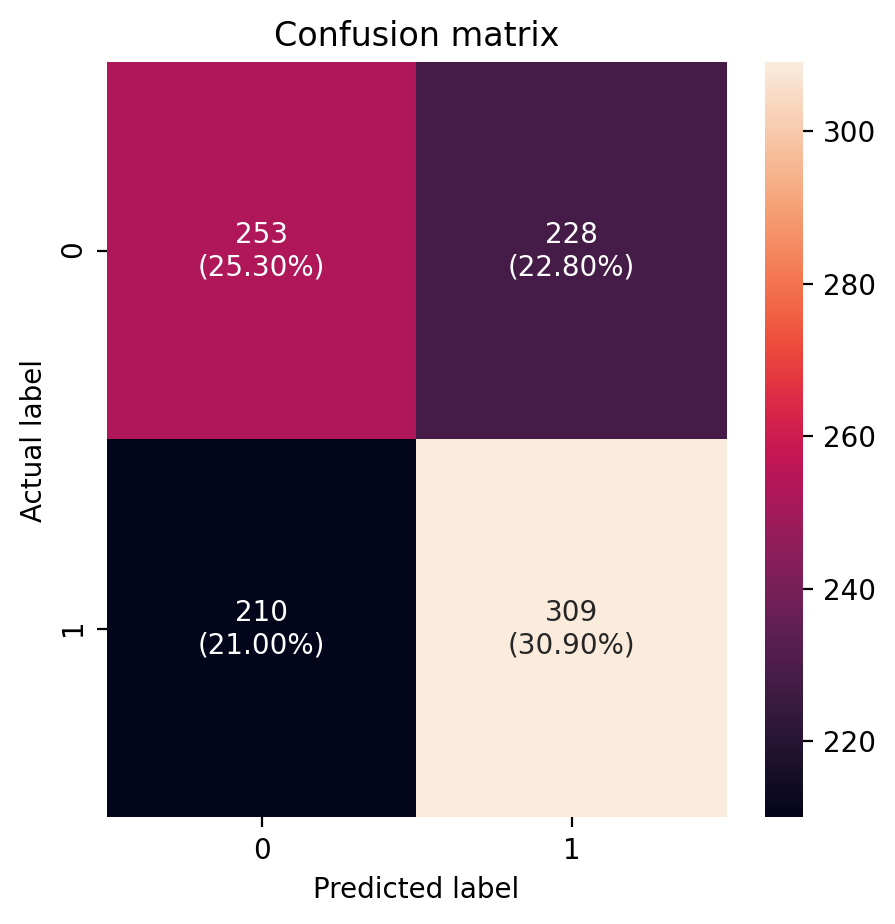

In [37]:
dec_list = evaluate(encoder_scratch, decoder_scratch, discriminator_scratch, test_dataloader, thresh_scratch)

On the testing set we can see that this way of training the model is indeed not the best one, with the confusion matrix clearly showing that the classifier is almost randomly choosing the labels.

<a id='four'></a>

# 4. Using a pre-trained AAE as a feature extractor

<a id='fourzero'></a>

## 4.0 Loading the pre-trained model

We'll first load the weights for each "sub-model":

In [38]:
encoder_weights = '/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/Model_Weights/AAE_Encoder.pth'
decoder_weights = '/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/Model_Weights/AAE_Decoder.pth'
discriminator_weights = '/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/Model_Weights/AAE_Discriminator.pth'

encoder_fe, decoder_fe, discriminator_fe = load_model_pretrained(encoder_weights, decoder_weights, discriminator_weights)

<a id='fourone'></a>

## 4.1 Evaluating

Instead of training this model, we'll just use it as is. According to the evaluation test, the model that we just loaded was trained only on images of strong gravitational lenses without substructure, i.e. `no_sub` labels. By making this model fixed, we can use the fact that it doesn't know how to handle `sub` images and use the model as an anomaly detector:

100%|██████████| 16/16 [00:02<00:00,  6.27it/s]


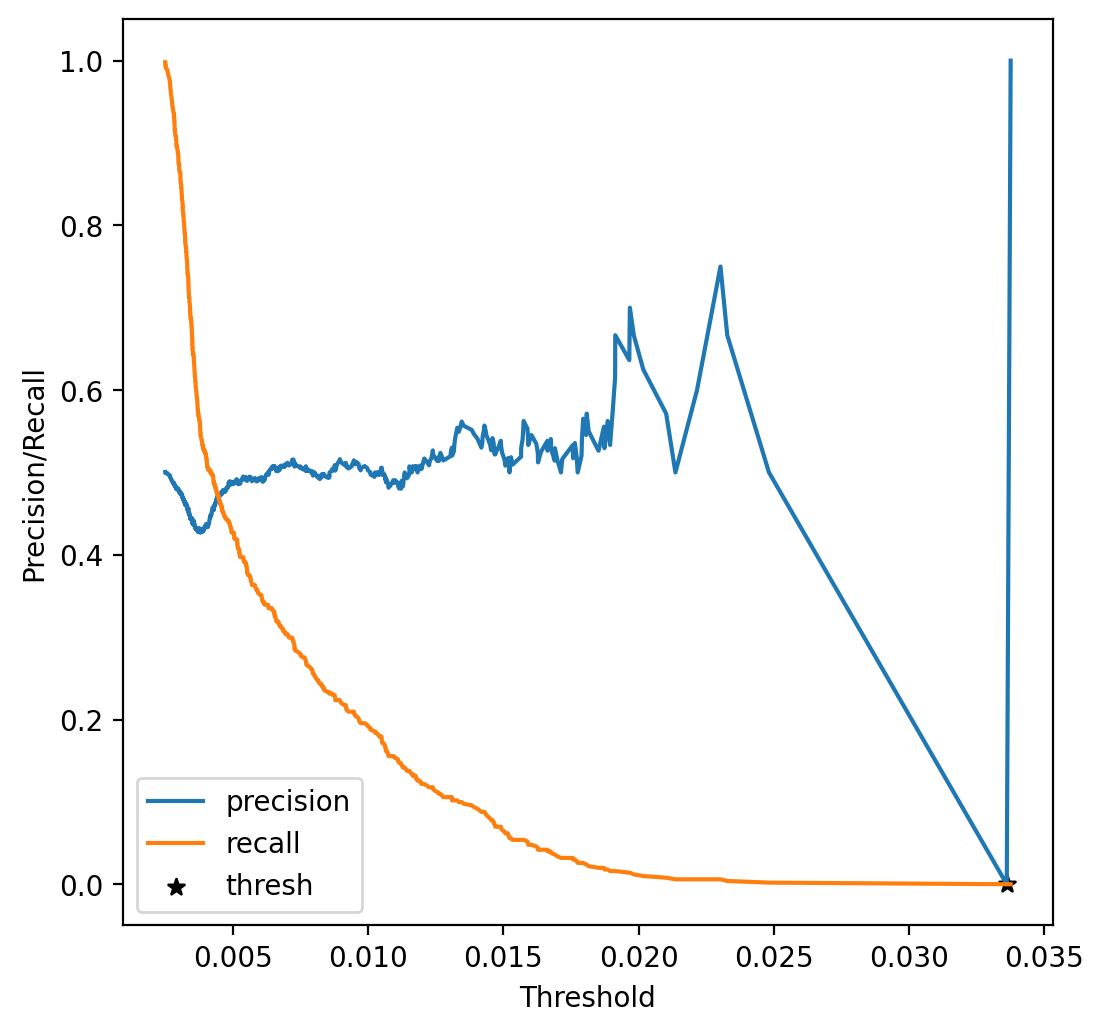

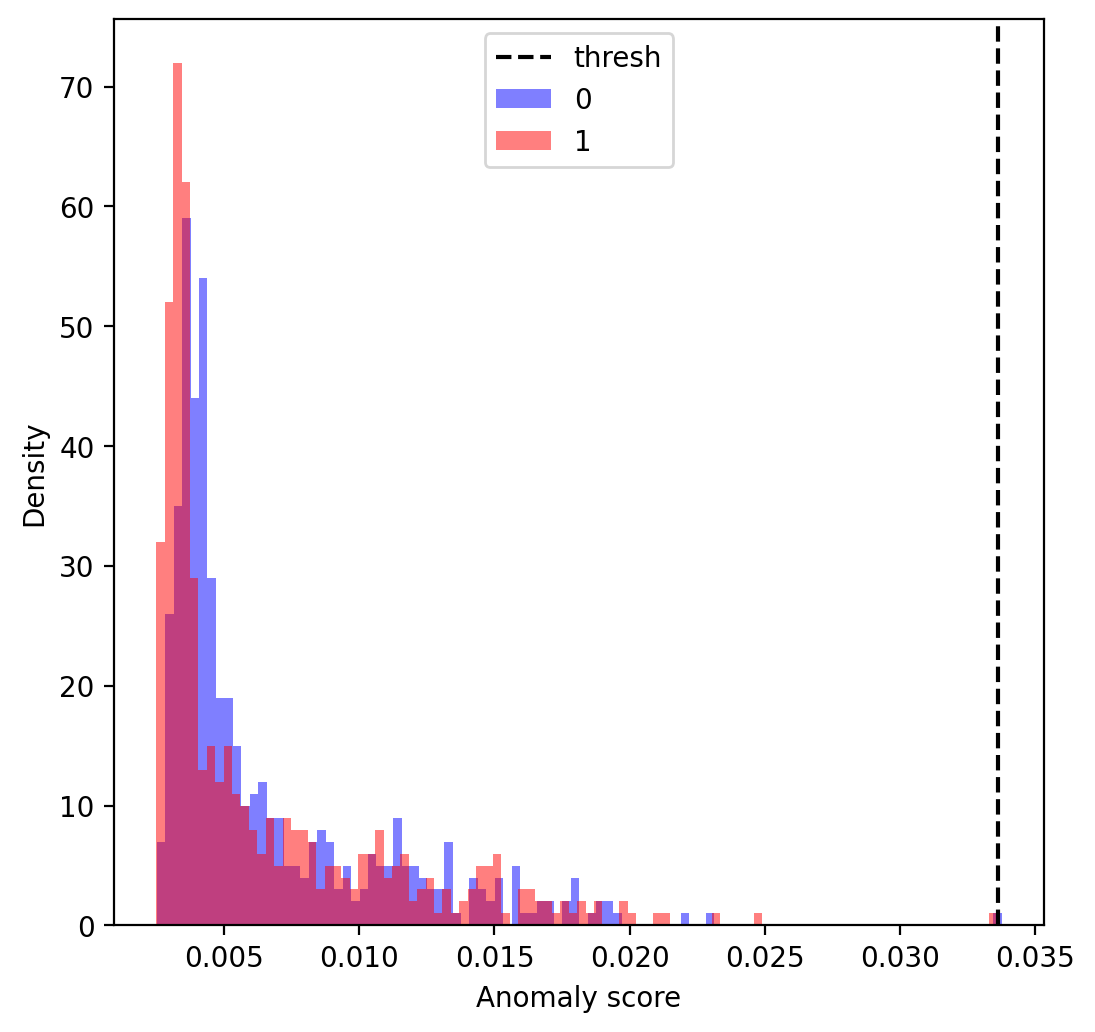

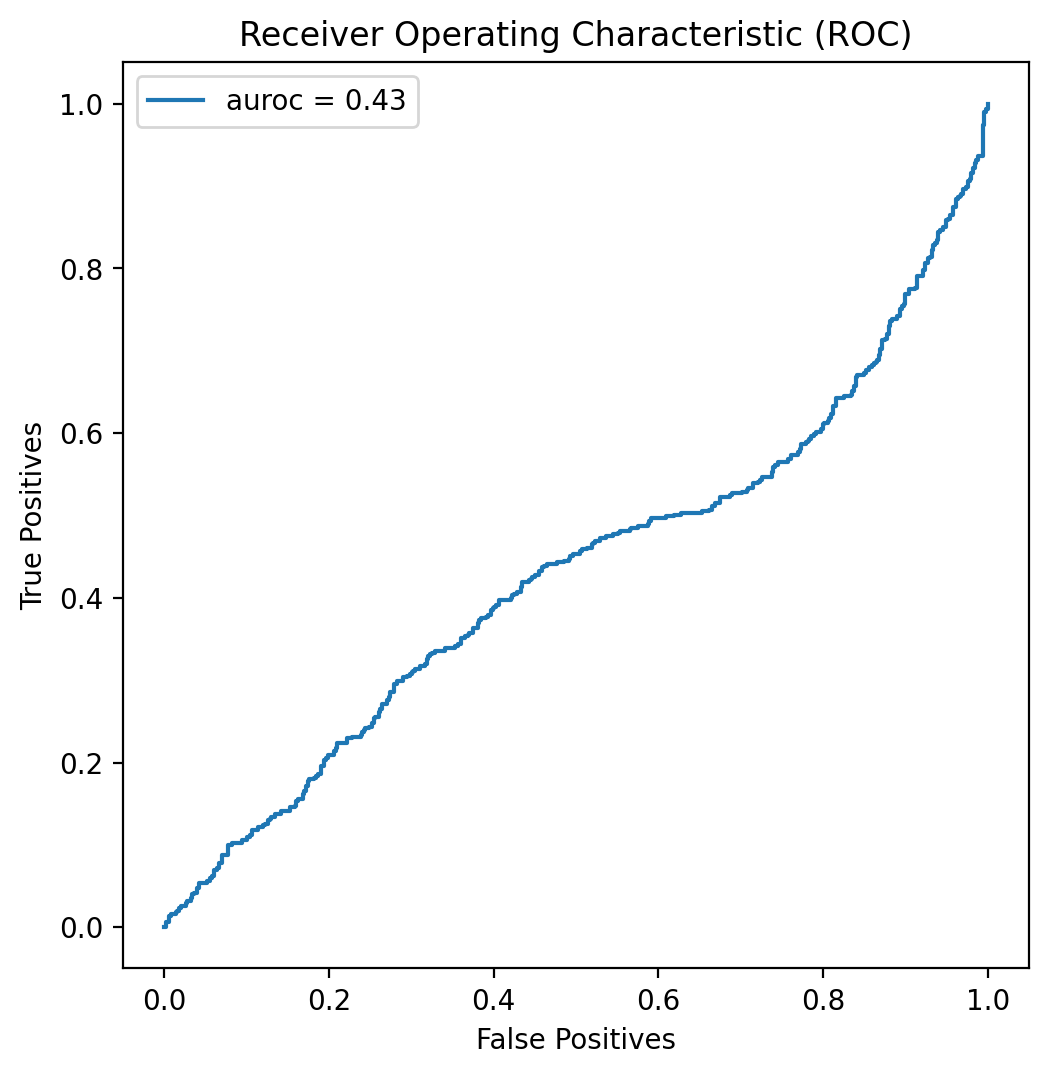

0.03361048549413681

In [39]:
thresh_fe = find_thresh(encoder_fe, decoder_fe, discriminator_fe, val_dataloader, viz=True)
thresh_fe

This plot gets pretty weird and unfortunetelly our method of using interpolation to get the threshold wasn't useful. Luckily, we can still see that a better value would be around $0.005$:

100%|██████████| 16/16 [00:02<00:00,  6.38it/s]


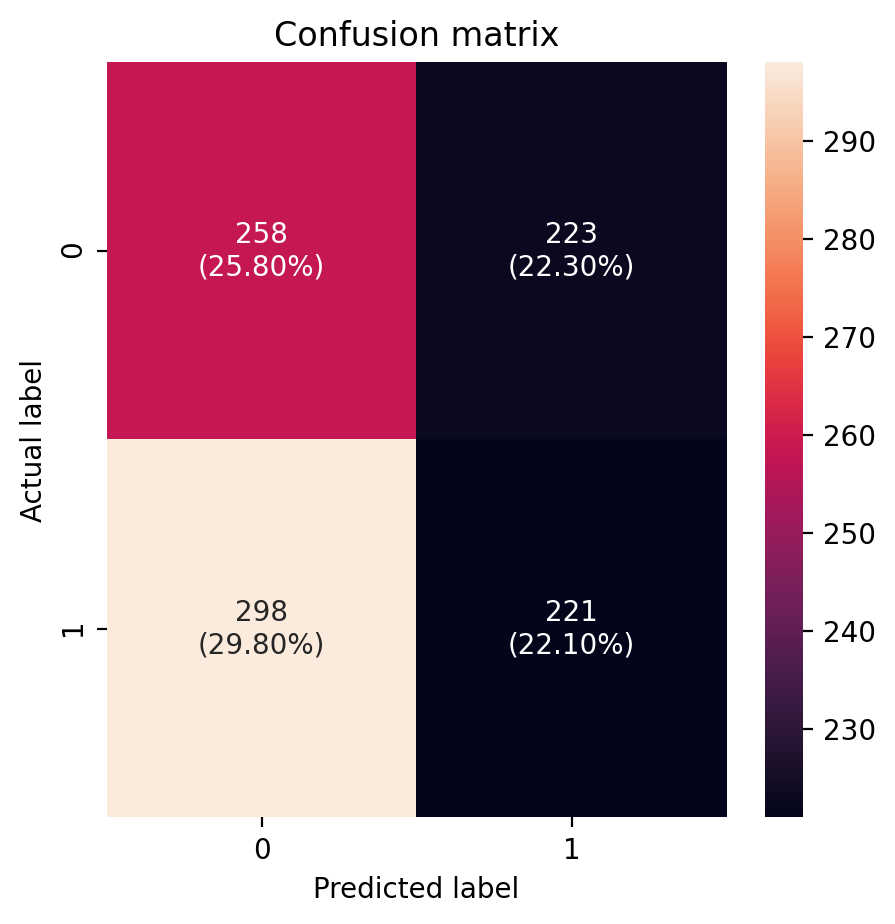

In [40]:
thresh_fe = 0.005
evaluate(encoder_fe, decoder_fe, discriminator_fe, test_dataloader, thresh_fe)

Even though we used a value close to the best trade-off we still get some very underwhelming results, unfortunetelly!

<a id='five'></a>

# 5. Finetuning a pre-trained AAE

<a id='fivezero'></a>

## 5.0 Loading the pre-trained model

We'll load the weights for each "sub-model":

In [41]:
encoder_weights = '/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/Model_Weights/AAE_Encoder.pth'
decoder_weights = '/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/Model_Weights/AAE_Decoder.pth'
discriminator_weights = '/content/drive/MyDrive/ml4sci/domain_adaptation/Domain Adaptation/Model_Weights/AAE_Discriminator.pth'

encoder_ft, decoder_ft, discriminator_ft = load_model_pretrained(encoder_weights, decoder_weights, discriminator_weights)

<a id='fiveone'></a>

## 5.1 Training the model

We'll perform training just like we did with the AAE from scratch. The only difference is that now we begin with the pre-trained weights:

Epoch 1/50: 100%|██████████| 63/63 [00:19<00:00,  3.30it/s]


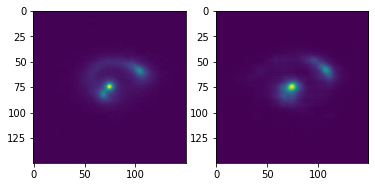

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 1/50] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.4895


Epoch 2/50: 100%|██████████| 63/63 [00:19<00:00,  3.31it/s]


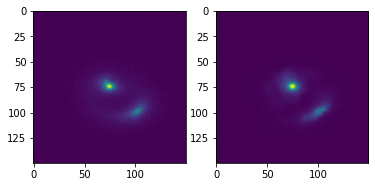

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 2/50] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3730


Epoch 3/50: 100%|██████████| 63/63 [00:19<00:00,  3.30it/s]


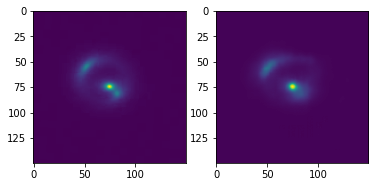

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 3/50] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.2917


Epoch 4/50: 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


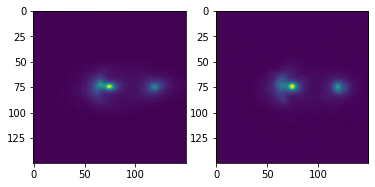

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 4/50] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.2966


Epoch 5/50: 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]


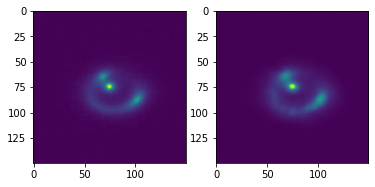

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 5/50] reconstruction loss: 0.0000; discriminator loss: 0.0009; generator loss: 0.3095


Epoch 6/50: 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


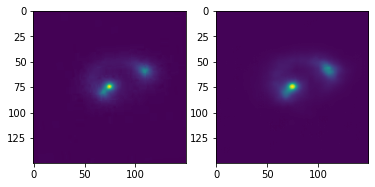

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 6/50] reconstruction loss: 0.0000; discriminator loss: 0.0008; generator loss: 0.3427


Epoch 7/50: 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]


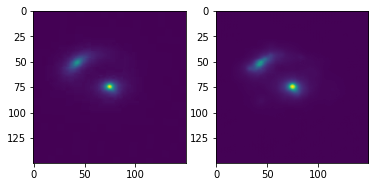

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 7/50] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3299


Epoch 8/50: 100%|██████████| 63/63 [00:19<00:00,  3.22it/s]


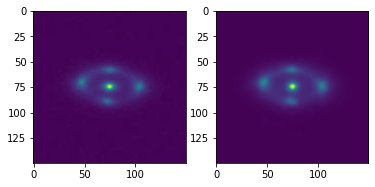

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 8/50] reconstruction loss: 0.0000; discriminator loss: 0.0010; generator loss: 0.3197


Epoch 9/50: 100%|██████████| 63/63 [00:19<00:00,  3.24it/s]


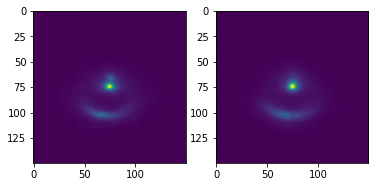

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 9/50] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3185


Epoch 10/50: 100%|██████████| 63/63 [00:19<00:00,  3.18it/s]


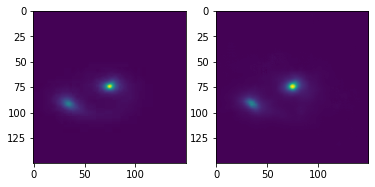

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 10/50] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3214


Epoch 11/50: 100%|██████████| 63/63 [00:19<00:00,  3.18it/s]


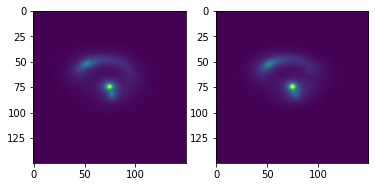

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 11/50] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3213


Epoch 12/50: 100%|██████████| 63/63 [00:19<00:00,  3.16it/s]


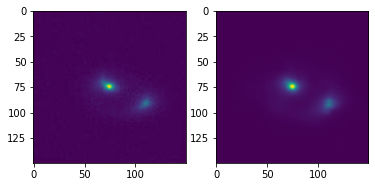

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 12/50] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3201


Epoch 13/50: 100%|██████████| 63/63 [00:19<00:00,  3.18it/s]


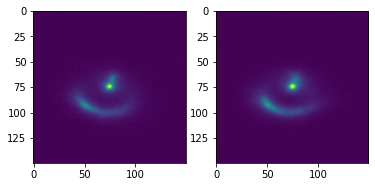

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 13/50] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3243


Epoch 14/50: 100%|██████████| 63/63 [00:20<00:00,  3.12it/s]


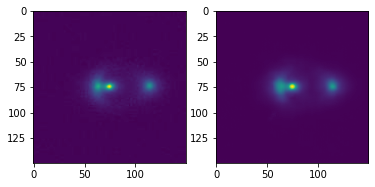

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 14/50] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3203


Epoch 15/50: 100%|██████████| 63/63 [00:20<00:00,  3.12it/s]


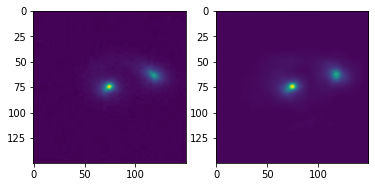

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 15/50] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3219


Epoch 16/50: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]


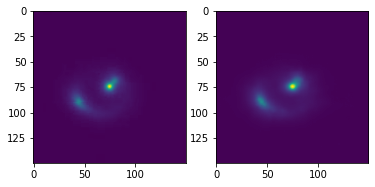

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 16/50] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3228


Epoch 17/50: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]


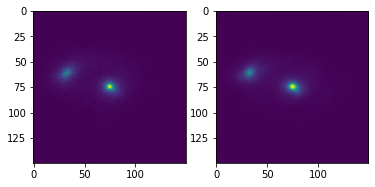

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 17/50] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3238


Epoch 18/50: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]


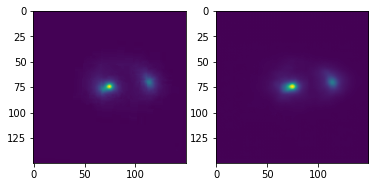

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 18/50] reconstruction loss: 0.0000; discriminator loss: 0.0009; generator loss: 0.3231


Epoch 19/50: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]


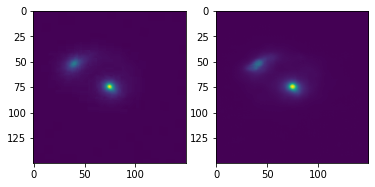

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 19/50] reconstruction loss: 0.0000; discriminator loss: 0.0008; generator loss: 0.3235


Epoch 20/50: 100%|██████████| 63/63 [00:20<00:00,  3.12it/s]


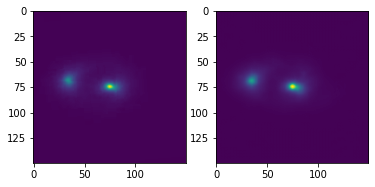

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 20/50] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3227


Epoch 21/50: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]


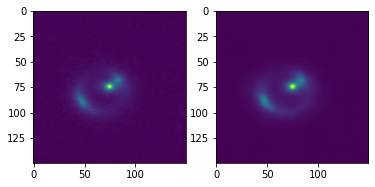

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 21/50] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3237


Epoch 22/50: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]


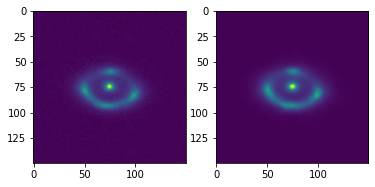

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 22/50] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3245


Epoch 23/50: 100%|██████████| 63/63 [00:20<00:00,  3.04it/s]


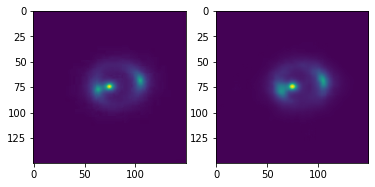

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 23/50] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3220


Epoch 24/50: 100%|██████████| 63/63 [00:20<00:00,  3.09it/s]


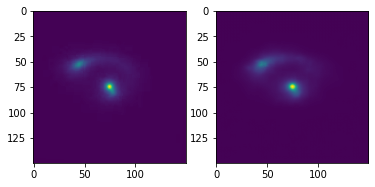

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 24/50] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3230


Epoch 25/50: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]


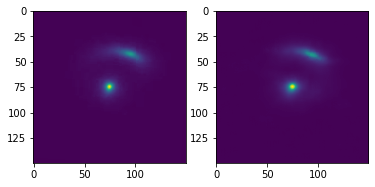

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 25/50] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3232


Epoch 26/50: 100%|██████████| 63/63 [00:20<00:00,  3.08it/s]


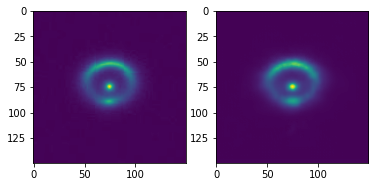

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 26/50] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3232


Epoch 27/50: 100%|██████████| 63/63 [00:20<00:00,  3.04it/s]


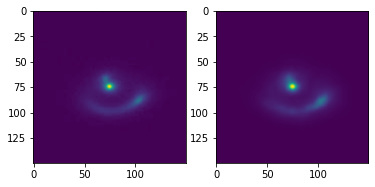

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 27/50] reconstruction loss: 0.0000; discriminator loss: 0.0008; generator loss: 0.3241


Epoch 28/50: 100%|██████████| 63/63 [00:20<00:00,  3.04it/s]


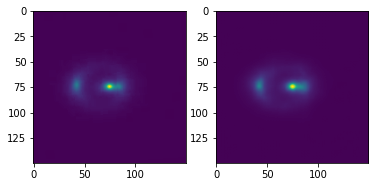

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 28/50] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3226


Epoch 29/50: 100%|██████████| 63/63 [00:20<00:00,  3.04it/s]


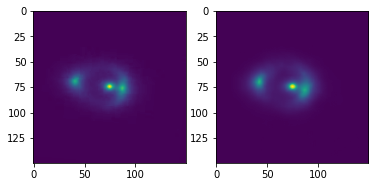

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 29/50] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3260


Epoch 30/50: 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]


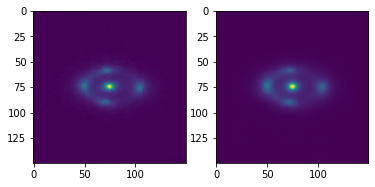

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 30/50] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3239


Epoch 31/50: 100%|██████████| 63/63 [00:20<00:00,  3.01it/s]


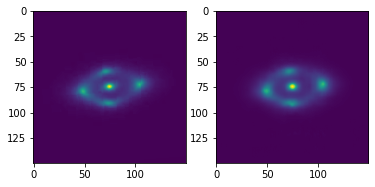

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 31/50] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3230


Epoch 32/50: 100%|██████████| 63/63 [00:20<00:00,  3.02it/s]


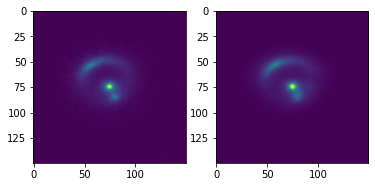

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 32/50] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3246


Epoch 33/50: 100%|██████████| 63/63 [00:20<00:00,  3.05it/s]


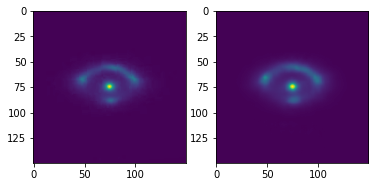

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 33/50] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3239


Epoch 34/50: 100%|██████████| 63/63 [00:20<00:00,  3.03it/s]


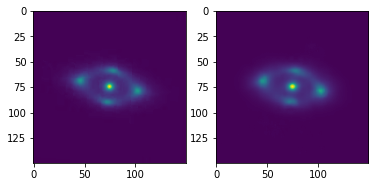

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 34/50] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3258


Epoch 35/50: 100%|██████████| 63/63 [00:20<00:00,  3.02it/s]


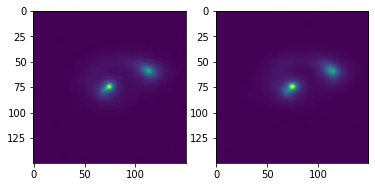

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 35/50] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3228


Epoch 36/50: 100%|██████████| 63/63 [00:20<00:00,  3.02it/s]


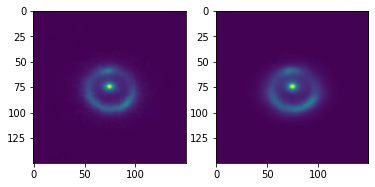

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 36/50] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3253


Epoch 37/50: 100%|██████████| 63/63 [00:20<00:00,  3.05it/s]


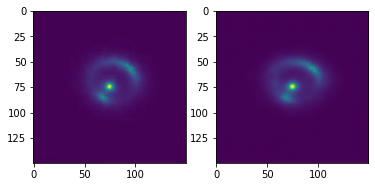

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 37/50] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3236


Epoch 38/50: 100%|██████████| 63/63 [00:20<00:00,  3.04it/s]


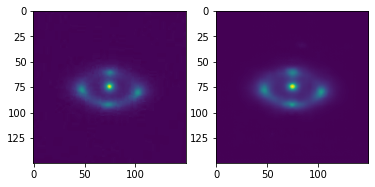

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 38/50] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3244


Epoch 39/50: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]


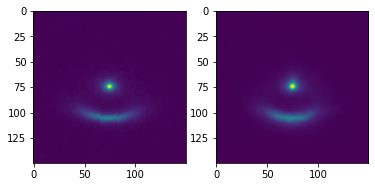

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 39/50] reconstruction loss: 0.0000; discriminator loss: 0.0003; generator loss: 0.3240


Epoch 40/50: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]


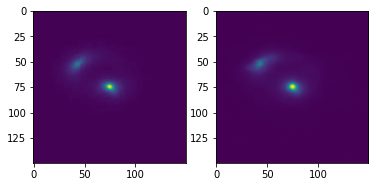

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 40/50] reconstruction loss: 0.0000; discriminator loss: 0.0005; generator loss: 0.3250


Epoch 41/50: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]


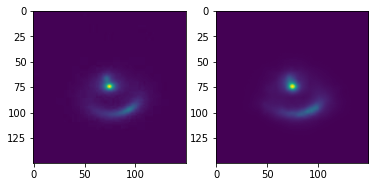

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 41/50] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3248


Epoch 42/50: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]


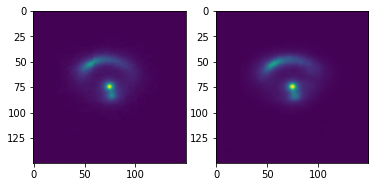

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 42/50] reconstruction loss: 0.0000; discriminator loss: 0.0004; generator loss: 0.3230


Epoch 43/50: 100%|██████████| 63/63 [00:20<00:00,  3.14it/s]


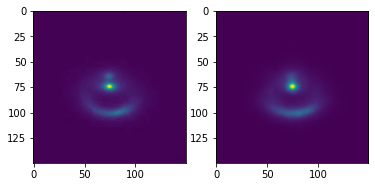

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 43/50] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3244


Epoch 44/50: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]


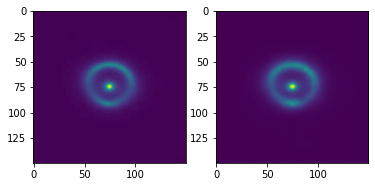

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 44/50] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3235


Epoch 45/50: 100%|██████████| 63/63 [00:19<00:00,  3.15it/s]


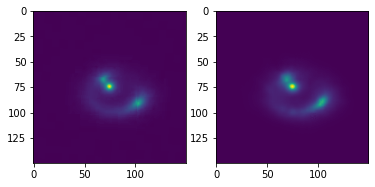

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 45/50] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3238


Epoch 46/50: 100%|██████████| 63/63 [00:19<00:00,  3.16it/s]


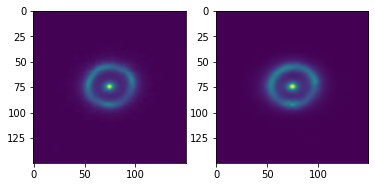

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 46/50] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3250


Epoch 47/50: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]


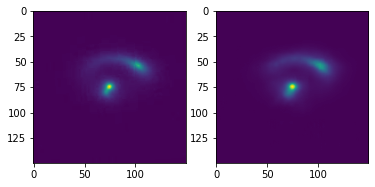

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 47/50] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3230


Epoch 48/50: 100%|██████████| 63/63 [00:20<00:00,  3.13it/s]


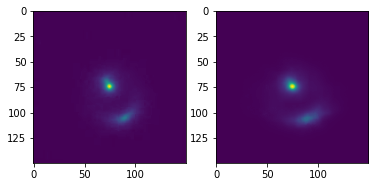

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 48/50] reconstruction loss: 0.0000; discriminator loss: 0.0006; generator loss: 0.3240


Epoch 49/50: 100%|██████████| 63/63 [00:20<00:00,  3.10it/s]


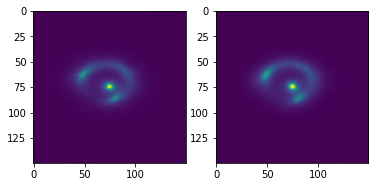

  0%|          | 0/63 [00:00<?, ?it/s]


[Epoch 49/50] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3248


Epoch 50/50: 100%|██████████| 63/63 [00:20<00:00,  3.12it/s]


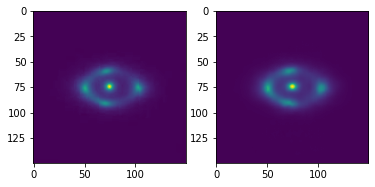


[Epoch 50/50] reconstruction loss: 0.0000; discriminator loss: 0.0007; generator loss: 0.3238


In [42]:
save_path_ft = os.path.join('/content/drive/MyDrive/ml4sci/domain_adaptation/', 'weights_history_ft.pt')
encoder_ft, decoder_ft, discriminator_ft, history_ft = train_model(encoder_ft, decoder_ft, discriminator_ft, train_dataloader, 50, save_path_ft, viz=True)

<a id='fivetwo'></a>

## 5.2 Visualizing the training metrics

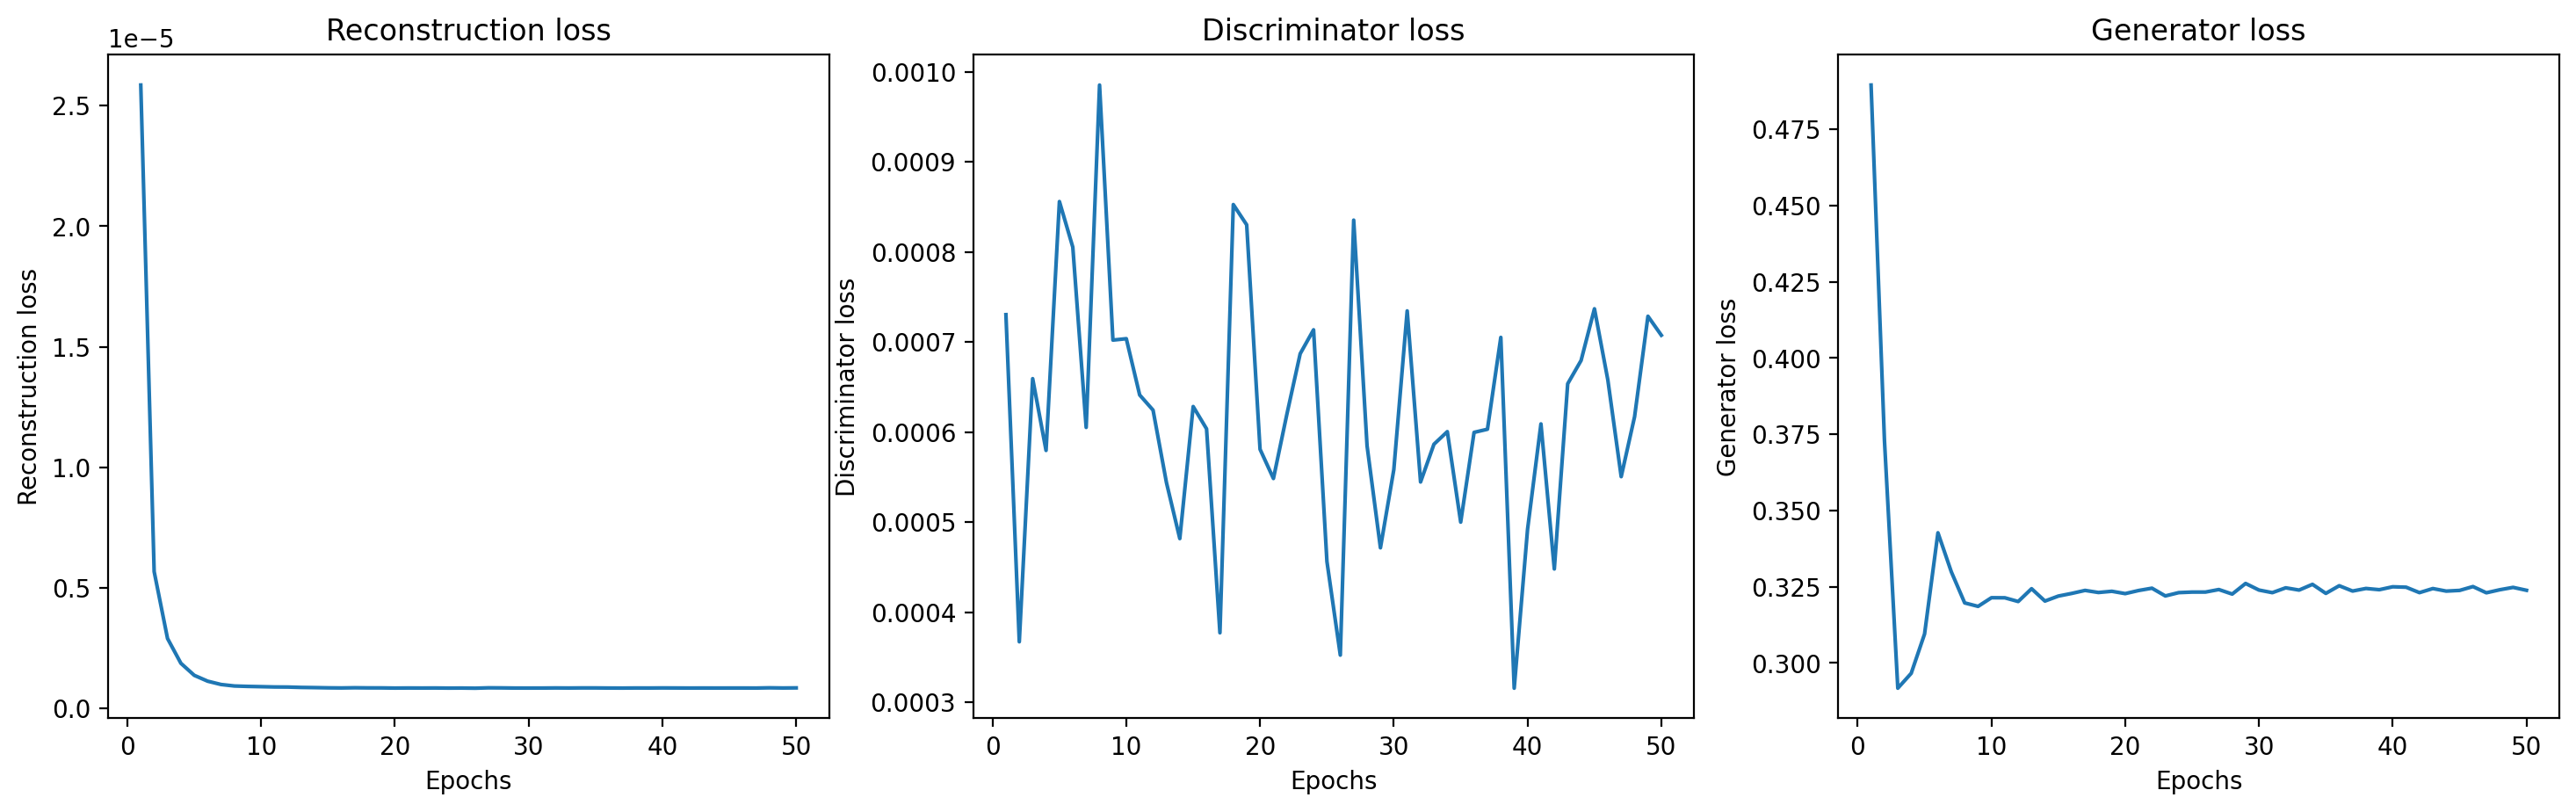

In [43]:
encoder_ft, decoder_ft, discriminator_ft, history_ft = load_weights_and_history(save_path_ft)
metrics(history_ft)

<a id='fivethree'></a>

## 5.3 Evaluating the model

100%|██████████| 16/16 [00:02<00:00,  6.29it/s]


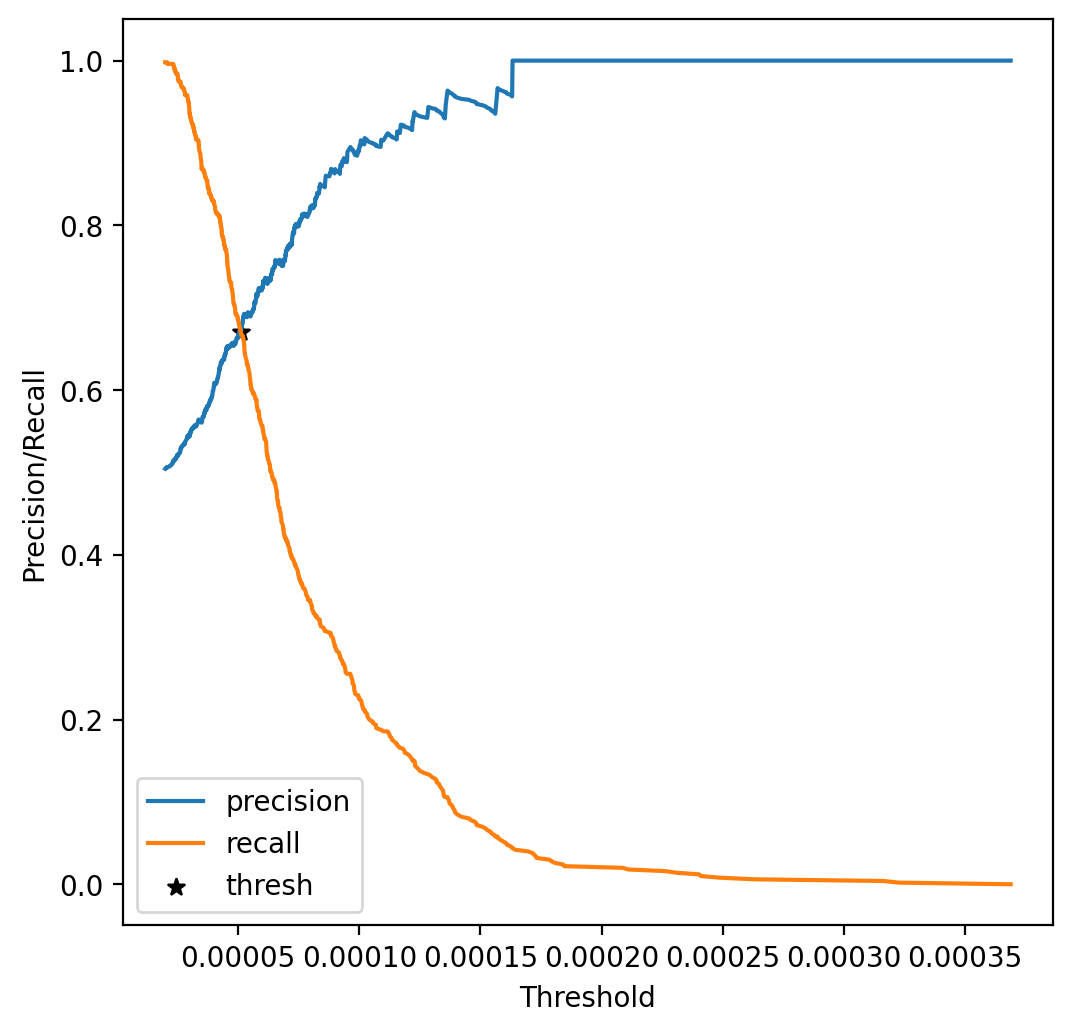

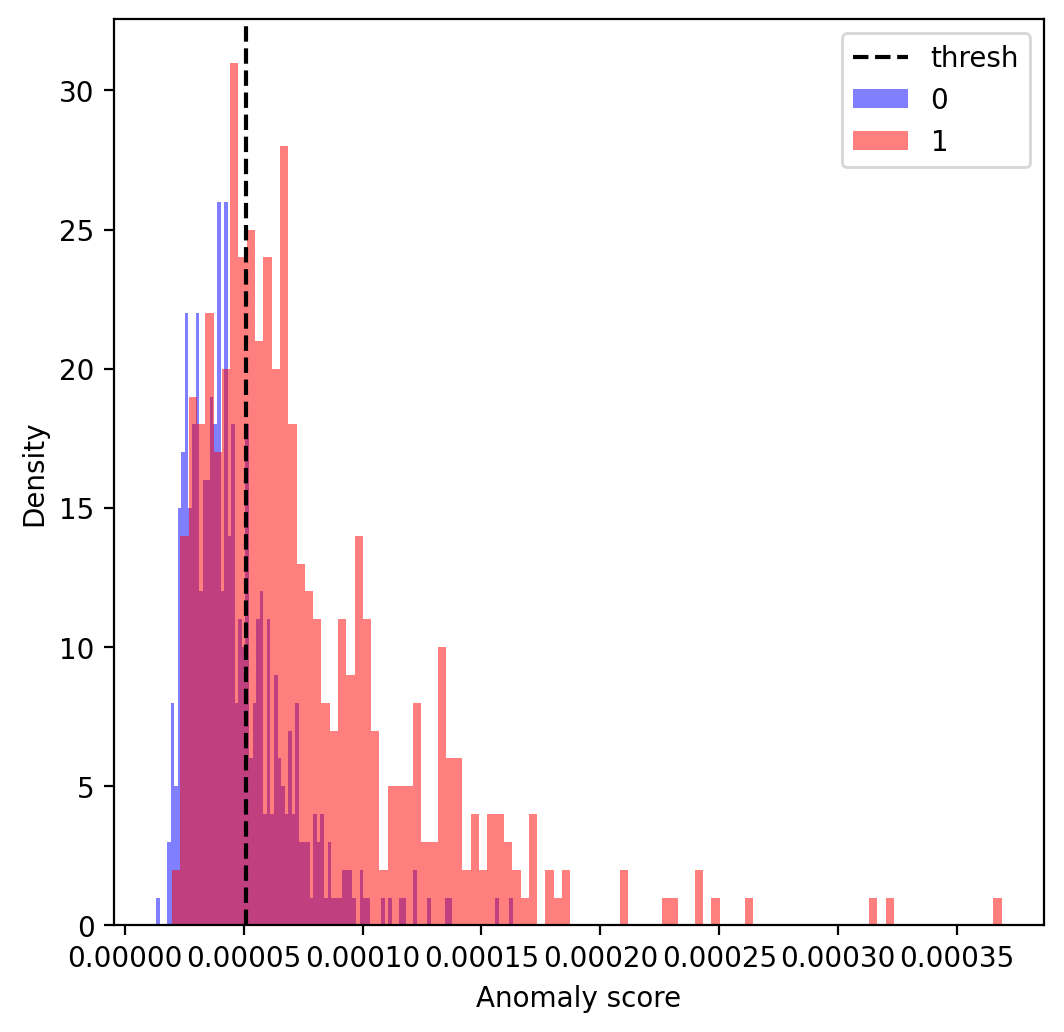

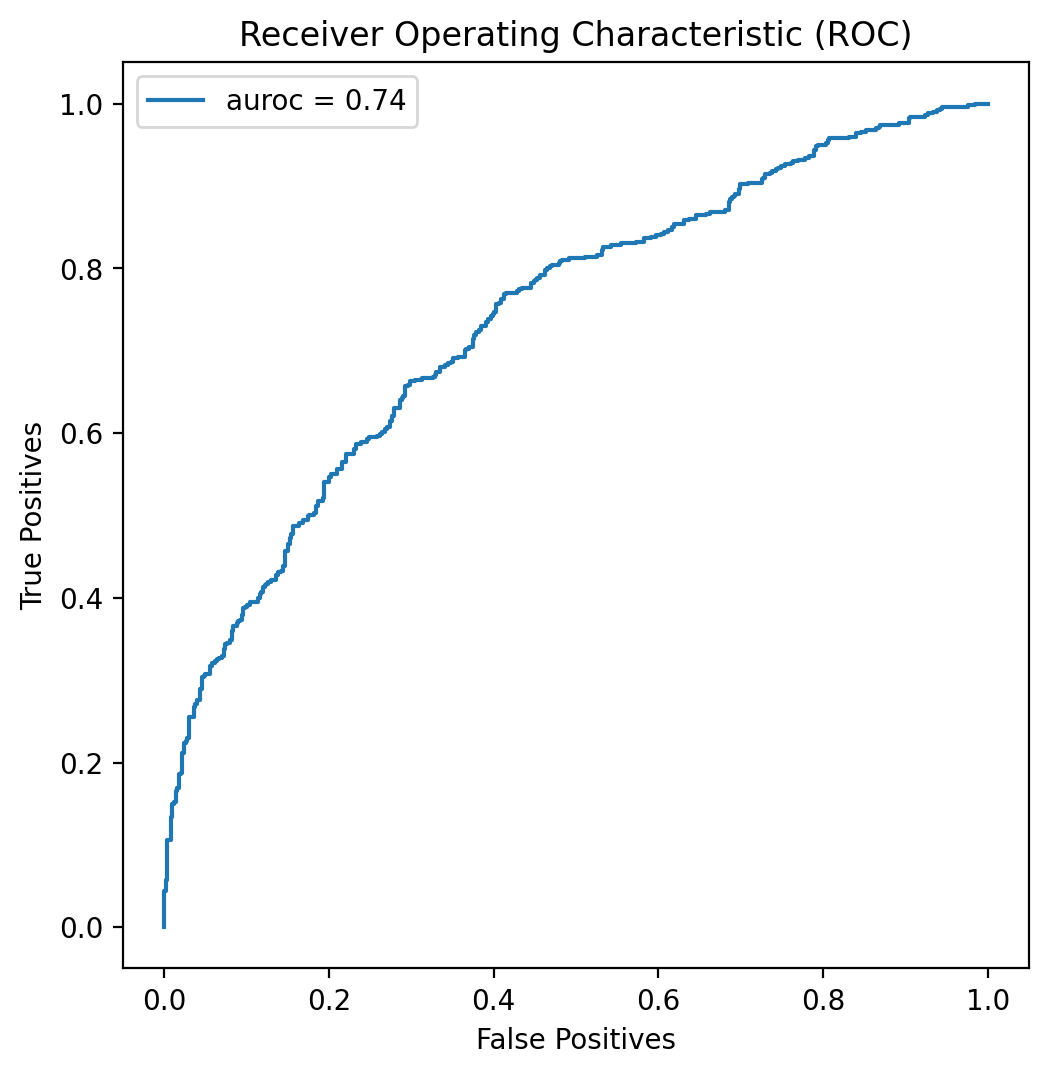

5.112197686685249e-05

In [44]:
thresh_ft = find_thresh(encoder_ft, decoder_ft, discriminator_ft, val_dataloader, viz=True)
thresh_ft

While there's still a big amount of overlap between the two labels we can separate the distributions much more clearly, which is very good! The ROC also has quite a good score!

100%|██████████| 16/16 [00:02<00:00,  6.42it/s]


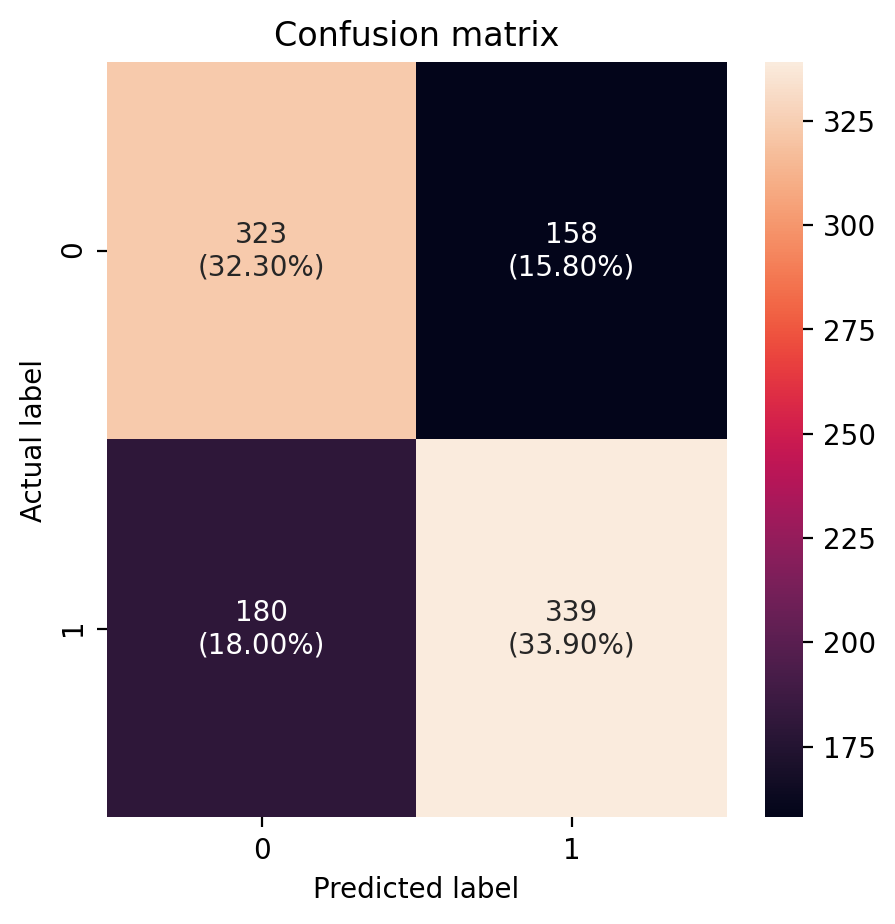

In [45]:
evaluate(encoder_ft, decoder_ft, discriminator_ft, test_dataloader, thresh_ft)

We can see that the model is performs quite well in the test set! Even though it still mislabels $ \approx 33\%$. Probably some tuning on the model's hyperparameters could improve the accuracy.

<a id='six'></a>

# 6. Next steps

A good next step would be, of course, to test other hyperparameters. Since there are so many different possibilities in an Adversarial Autoencoder architecture (different learning rates, different schedulers for each learning rate, different optimizers, different epochs) this would probably take a while! Nevertheless, it's an important step when searching for the best performance.

Another pretty useful thing would be to check different distributions. I used a very basic normal distribution with mean $0$ and variance $1$. Other more complex distributions could be tested, such as the one seen [here](https://github.com/GitiHubi/deepAD/blob/master/KDD_2019_Lab.ipynb).

The training metrics show that the generator loss usually hits a plateau. This is a problem because the model doesn't improve anymore. Using another network architecture or trying different optimizer configurations could maybe counter this.

Finally, a class implementation of the AAE "instantiating-loading weights-training-visualizing metrics-evaluating" pipeline would be especially useful to let this work be more reproducible. A concept of how this implementation could be made and used can be seen in my first submission [here](https://github.com/zysymu/ml4sci/blob/main/domain_adaptation/domain_adaptation.ipynb). Note that the results are pretty bad in this implementation for lots of reasons, it's just a way of showing a possible structure.

<a id='ref'></a>

# REFERENCES:

- https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098
- https://github.com/DeepLense-Unsupervised/unsupervised-lensing
- https://arxiv.org/pdf/1908.00734.pdf
- https://arxiv.org/pdf/2008.12731.pdf
- https://arxiv.org/pdf/1902.06924.pdf
- https://github.com/fducau/AAE_pytorch
- https://towardsdatascience.com/a-wizards-guide-to-adversarial-autoencoders-part-2-exploring-latent-space-with-adversarial-2d53a6f8a4f9
- https://blog.paperspace.com/adversarial-autoencoders-with-pytorch/
- https://github.com/bfarzin/pytorch_aae
- https://github.com/sksq96/pytorch-vae
- https://github.com/neale/Adversarial-Autoencoder
- https://github.com/shaharazulay/adversarial-autoencoder-classifier